---
---

### This notebook presents the results of the PCA-VAR approach to predicting IVS with features vs surface only. This is how we are going to measure the project pipelines to indetify encoders/decoders and temporal models that can beat the pipeline.

---
---

In [1]:
# Set Keras 3 backend to PyTorch and enable CUDA
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Keras backend:", keras.backend.backend())
print("PyTorch CUDA available:", torch.cuda.is_available())
print("Selected device:", device)

Keras backend: torch
PyTorch CUDA available: True
Selected device: cuda


In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))


['date', 'maturity', 'tau', 'S0', 'K', 'rel_strike', 'q', 'r', 'market_iv', 'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8', 'rf_9', 'rf_10', 'rf_11', 'rf_12', 'rf_13', 'rf_14', 'rf_15', 'rf_16', 'rf_17', 'rf_18', 'rf_19', 'rf_20', 'rf_21', 'rf_22', 'rf_23', 'rf_24', 'rf_25', 'rf_26', 'rf_27', 'rf_28', 'rf_29', 'rf_30', 'rf_31', 'ssvi_theta', 'ssvi_rho', 'ssvi_beta', 'heston_kappa', 'heston_theta', 'heston_sigma', 'heston_rho', 'heston_v0']
(141790, 49)


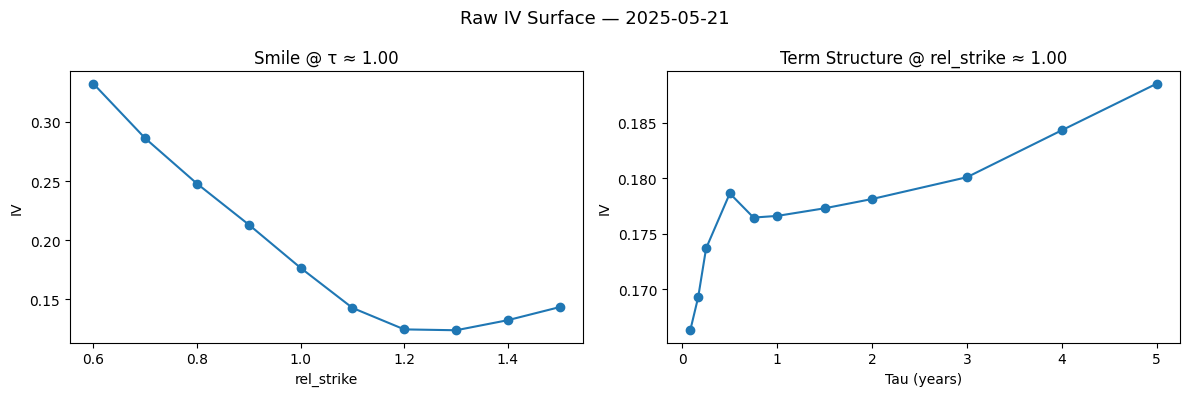

In [3]:

from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")

print(df.columns.tolist())
print(df.shape)
# === Global Variables ===
global LOOKBACK, BATCH_SIZE, LATENT_DIM, SURFACE_SHAPE, FEATURE_DIM
global TARGET_DATE, TARGET_STRIKE, TARGET_TAU

LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)  

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False

from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)



In [4]:
import pandas as pd

maturity_to_tau = {
   '1m': 1/12, '2m': 2/12, '3m': 3/12, '6m': 0.5, '9m': 0.75,
   '1y': 1.0, '18m': 1.5, '2y': 2.0, '3y': 3.0, '4y': 4.0, '5y': 5.0
}

# filter and pivot raw surfaces
surface_df = df.copy()
surface_df = surface_df.dropna(subset=["market_iv", "rel_strike", "maturity"])
surface_df = surface_df.sort_values(["date", "maturity", "rel_strike"])

# get sorted unique grid
dates = sorted(surface_df["date"].unique())
rel_strikes = sorted(surface_df["rel_strike"].unique())
maturities = sorted(maturity_to_tau.keys(), key=lambda m: maturity_to_tau[m])

# pivot to wide matrix
pivot_df = surface_df.pivot_table(
   index="date",
   columns=["maturity", "rel_strike"],
   values="market_iv"
).reindex(index=dates, columns=pd.MultiIndex.from_product([maturities, rel_strikes]))

# drop any rows with missing values
pivot_df = pivot_df.dropna()

# create inputs
X = pivot_df.values  # shape (t, m*k)
print(f"x shape (t, m*k): {X.shape}")

# train/test split
T = len(X)
T_train = int(0.7 * T)
X_train, X_test = X[:T_train], X[T_train:]

x shape (t, m*k): (1289, 110)


In [5]:
from models.encoder_pca import PCAEncoder
from models.forecaster_var import VARForecaster, run_pca_var_forecast
from sklearn.metrics import root_mean_squared_error

configs = [
    ("PCA_VAR without Delta", dict(use_delta=False, standardize=False, demean_surface=False)),
    ("PCA_VAR without Delta, Standardized", dict(use_delta=False, standardize=True, demean_surface=False)),
    ("PCA_VAR with Delta", dict(use_delta=True, standardize=False, demean_surface=False)),
    ("PCA_VAR with Delta, Standardized", dict(use_delta=True, standardize=True, demean_surface=False)),
    ("PCA_VAR without Delta, Demeaned Surface (true mean)", dict(use_delta=False, standardize=False, demean_surface=True, mean_mode="true")),
    ("PCA_VAR without Delta, Demeaned Surface (last mean)", dict(use_delta=False, standardize=False, demean_surface=True, mean_mode="last")),
    ("PCA_VAR without Delta, Demeaned Surface (global mean)", dict(use_delta=False, standardize=False, demean_surface=True, mean_mode="global")),
    ("PCA_VAR without Delta, Demeaned Surface (predicted mean)", dict(use_delta=False, standardize=False, demean_surface=True, mean_mode="predicted")),
]

for label, config in configs:
    print(label)
    Z_forecast, Z_test, Z_train, X_recon, X_true, metrics, pca, var_model, _ = run_pca_var_forecast(
        X_train, X_test,
        latent_dim=5,
        **config
    )

    rmse_z, rmse_sigma = metrics
    print(f" RMSE_z: {rmse_z:.4f} | RMSE_σ: {rmse_sigma:.4f}")
    print("X_recon std:", X_recon.std())
    print()


PCA_VAR without Delta
rmse_z: 0.0974 | rmse_σ: 0.0256
 RMSE_z: 0.0974 | RMSE_σ: 0.0256
X_recon std: 0.08292921731623516

PCA_VAR without Delta, Standardized
rmse_z: 0.8149 | rmse_σ: 0.1123
 RMSE_z: 0.8149 | RMSE_σ: 0.1123
X_recon std: 0.12984793429379865

PCA_VAR with Delta
rmse_z: 0.2553 | rmse_σ: 0.0744
 RMSE_z: 0.2553 | RMSE_σ: 0.0744
X_recon std: 0.06948427081883697

PCA_VAR with Delta, Standardized
rmse_z: 1.7255 | rmse_σ: 0.3105
 RMSE_z: 1.7255 | RMSE_σ: 0.3105
X_recon std: 0.23544546828517954

PCA_VAR without Delta, Demeaned Surface (true mean)
using mean_mode='true' for demeaning: 0.1962
rmse_z: 0.0497 | rmse_σ: 0.2001
 RMSE_z: 0.0497 | RMSE_σ: 0.2001
X_recon std: 0.08676473575381397

PCA_VAR without Delta, Demeaned Surface (last mean)
using mean_mode='last' for demeaning: 0.1985
rmse_z: 0.0497 | rmse_σ: 0.1989
 RMSE_z: 0.0497 | RMSE_σ: 0.1989
X_recon std: 0.08564293545319948

PCA_VAR without Delta, Demeaned Surface (global mean)
using mean_mode='global' for demeaning: 0.2406
r


We forecast implied volatility surfaces using a PCA–VAR pipeline:

1. **PCA encoding**: Reduces the surface to a low-dimensional latent vector \( Z_t \).
2. **VAR forecasting**: Predicts future latent vector \( Z_{t+1} \) using a VAR model.
3. **Decoding**: Reconstructs the surface \( \hat{X}_{t+1} \) from \( Z_{t+1} \).
4. **Demeaning (optional)**: Removes surface-level mean to improve latent structure; the mean is later re-added using a separate AR(1) forecast.

### Configurations Compared

We tested combinations of:

- Latent differencing (`use_delta`)
- Latent standardization
- Surface demeaning
- Mean re-anchoring: `"true"`, `"last"`, `"global"`, and `"predicted"` (via AR(1))

Metrics:

- `RMSE_z`: error in latent space
- `RMSE_σ`: surface reconstruction error
- `X_recon.std`: decoded surface expressivity

### Final Configuration

The best performance was achieved with:

- `use_delta = False`
- `standardize = False`
- `demean_surface = True`
- `mean_mode = "predicted"`

This setup had the lowest RMSE in latent space and strong surface-level accuracy, while remaining consistent with a true forecasting setup (no future leakage).



PCA_VAR without Delta (demeaned, mean_mode = predicted)
using mean_mode='predicted' for demeaning: 0.1997
rmse_z: 0.0265 | rmse_σ: 0.2341
True surface mean: 0.21147345627157377
Decoded surface mean: 0.23663382941379002
X_mean (last): [0.23663383]


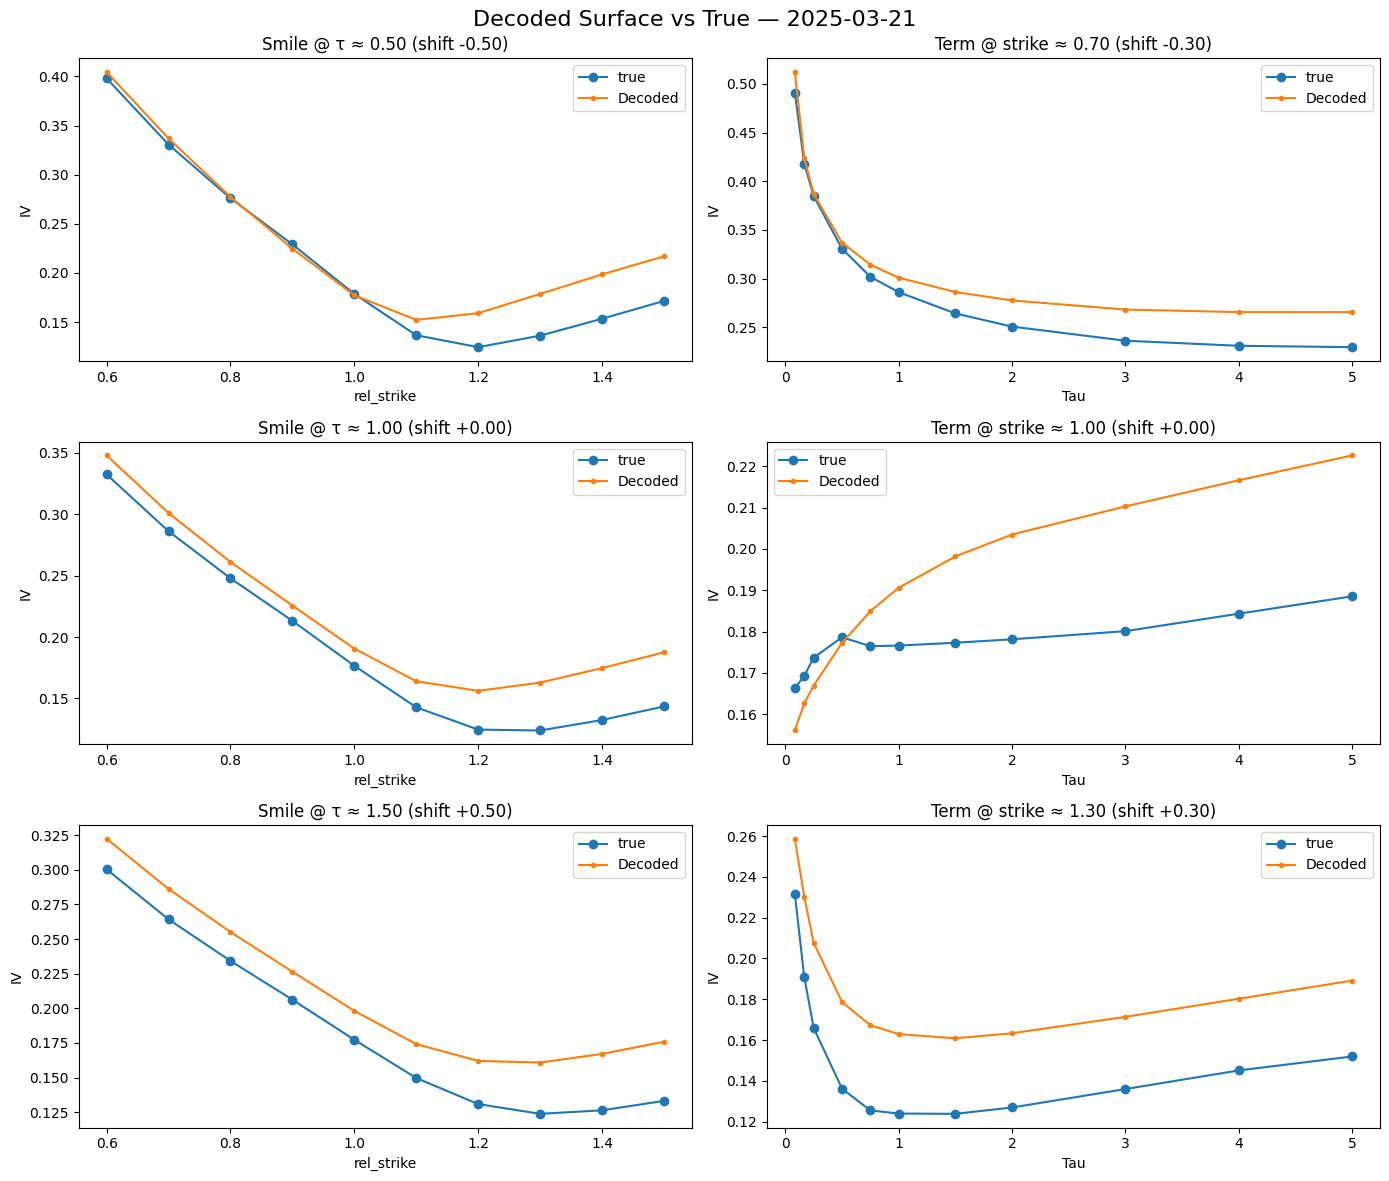

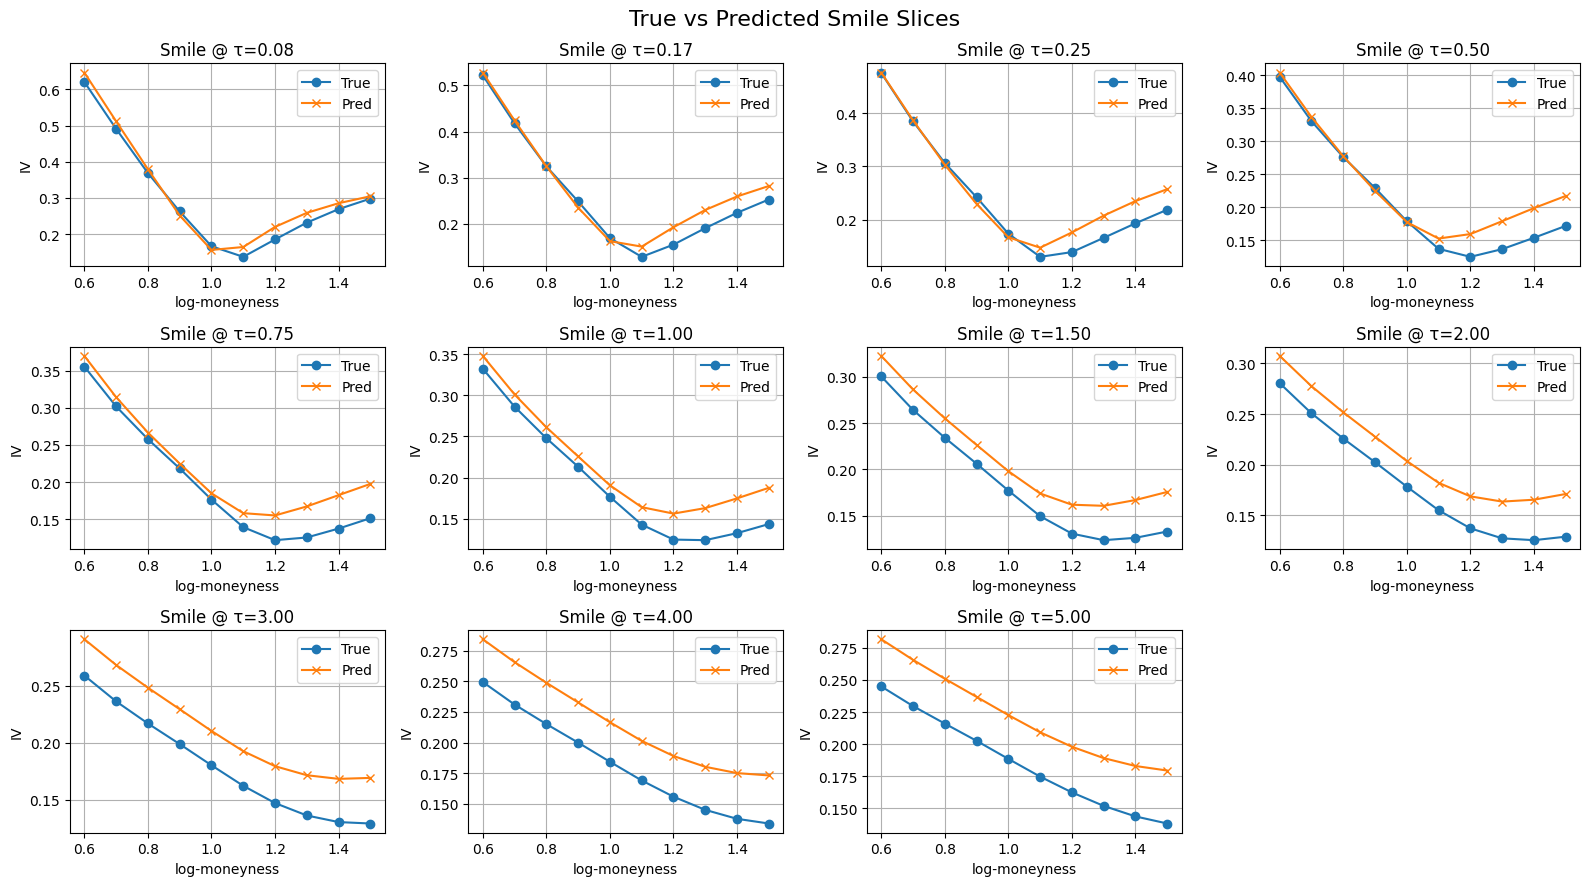

In [6]:
import numpy as np
from utils.plotting import plot_iv_slices_shifts

mean_mode = "predicted"  # Choose from: "true", "last", "global", "predicted"
print(f"PCA_VAR without Delta (demeaned, mean_mode = {mean_mode})")


Z_forecast, Z_test, Z_train, X_recon, X_true, metrics, pca, var_model, X_mean = run_pca_var_forecast(
    X_train, X_test,
    latent_dim=LATENT_DIM,
    use_delta=False,
    standardize=False,
    demean_surface=True,
    mean_mode=mean_mode
)

#  Recover surface shape from X_test
M, K = 11, 10  # manually set based on known surface shape
taus = np.array(sorted(maturity_to_tau.values()))
rel_strikes = np.array(sorted(df["rel_strike"].unique()))



TARGET_DATE = "2025-03-21"
# Get the date corresponding to the last test surface
decoded_date =  TARGET_DATE# str(pivot_df.index[-len(X_test) + (X_test.shape[0] - 1)])

# last surface
true_surface_t = X_test[-1].reshape(M, K)
recon_surface_t = X_recon[-1].reshape(M, K)

print("True surface mean:", true_surface_t.mean())
print("Decoded surface mean:", recon_surface_t.mean())
print("X_mean (last):", X_mean[-1] if X_mean is not None else "None")


plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=taus,
    rel_strikes=rel_strikes,
    decoded_date=decoded_date,
    target_tau=1.0,
    target_strike=1.0
)


from utils.plotting import plot_smile_slices_comparison

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=rel_strikes,
    taus=taus
)

### Forecasting Surface Level: Impact of Mean Re-anchoring

In our PCA–VAR pipeline, we explored multiple strategies for reintroducing the surface mean after latent forecasting. This is critical when working with demeaned surfaces, as PCA primarily captures relative variation (smile, term structure) rather than absolute level.

We tested four approaches:
- `"true"`: adds the actual future surface mean (not feasible in real forecasting)
- `"last"`: reuses the final mean from the training set
- `"global"`: uses the average training mean across all dates
- `"predicted"`: fits an AR(1) model on training means and forecasts forward

While `mean_mode="true"` gives the lowest RMSE, it is artificially optimistic, as it peeks into the test set. `"global"` and `"last"` underperform due to their static nature. The `"predicted"` option, which extrapolates using AR(1), provides a viable and realistic trade-off—recovering the surface level with acceptable accuracy.

This highlights that proper level modeling is essential for true forecasting and cannot rely on implicit assumptions or peeking into future data.


In [7]:

import importlib
import data.feature_engineering
importlib.reload(data.feature_engineering)


from data.feature_engineering import (
    compute_log_returns, compute_realized_vol,
    compress_yield_curve, compute_rolling_features,
    compute_smile_features_by_maturity, compute_term_structure_features
)

# Identify interest rate curve columns
rf_cols = [col for col in df.columns if col.startswith("rf_")]


# Step 1: One row per date for macro features
daily_df = df.sort_values(["date", "maturity"]).groupby("date").first()

# Step 2: Base features
returns = compute_log_returns(daily_df)
realized_vol = compute_realized_vol(returns, window=5)
r_ma, r_z = compute_rolling_features(returns)
v_ma, v_z = compute_rolling_features(realized_vol)
curve_features = compress_yield_curve(daily_df, rf_cols)

# Step 3: Smile features (avg across maturities)
smile_by_maturity = compute_smile_features_by_maturity(df)
smile_features = smile_by_maturity.groupby("date").mean()

term_features = compute_term_structure_features(df, tau_map=maturity_to_tau)

# Step 5: Merge and align
features_df = pd.concat(
    [returns, r_ma, r_z, realized_vol, v_ma, v_z, curve_features], axis=1
).join([smile_features, term_features], how="inner")

features_df = features_df.dropna()
features_df = features_df.loc[features_df.index.intersection(pivot_df.index)]

nan_counts = features_df.isna().sum()
print(nan_counts[nan_counts > 0])


import numpy as np
assert np.all(np.isfinite(features_df.values)), " Non-finite values detected in features_df"

import numpy as np

F = features_df.values
print(" F shape:", F.shape)
print("NaNs:", np.isnan(F).sum())
print("Infs:", np.isinf(F).sum())
print("All finite:", np.isfinite(F).all())


print(" Final enriched features shape:", features_df.shape)


Series([], dtype: int64)
 F shape: (1265, 26)
NaNs: 0
Infs: 0
All finite: True
 Final enriched features shape: (1265, 26)


X shape (T, M*K): (1289, 110)
using mean_mode='global' for demeaning: 0.2406
rmse_z: 0.0379 | rmse_σ: 0.2409
RMSE (surface): 0.24090095961392138


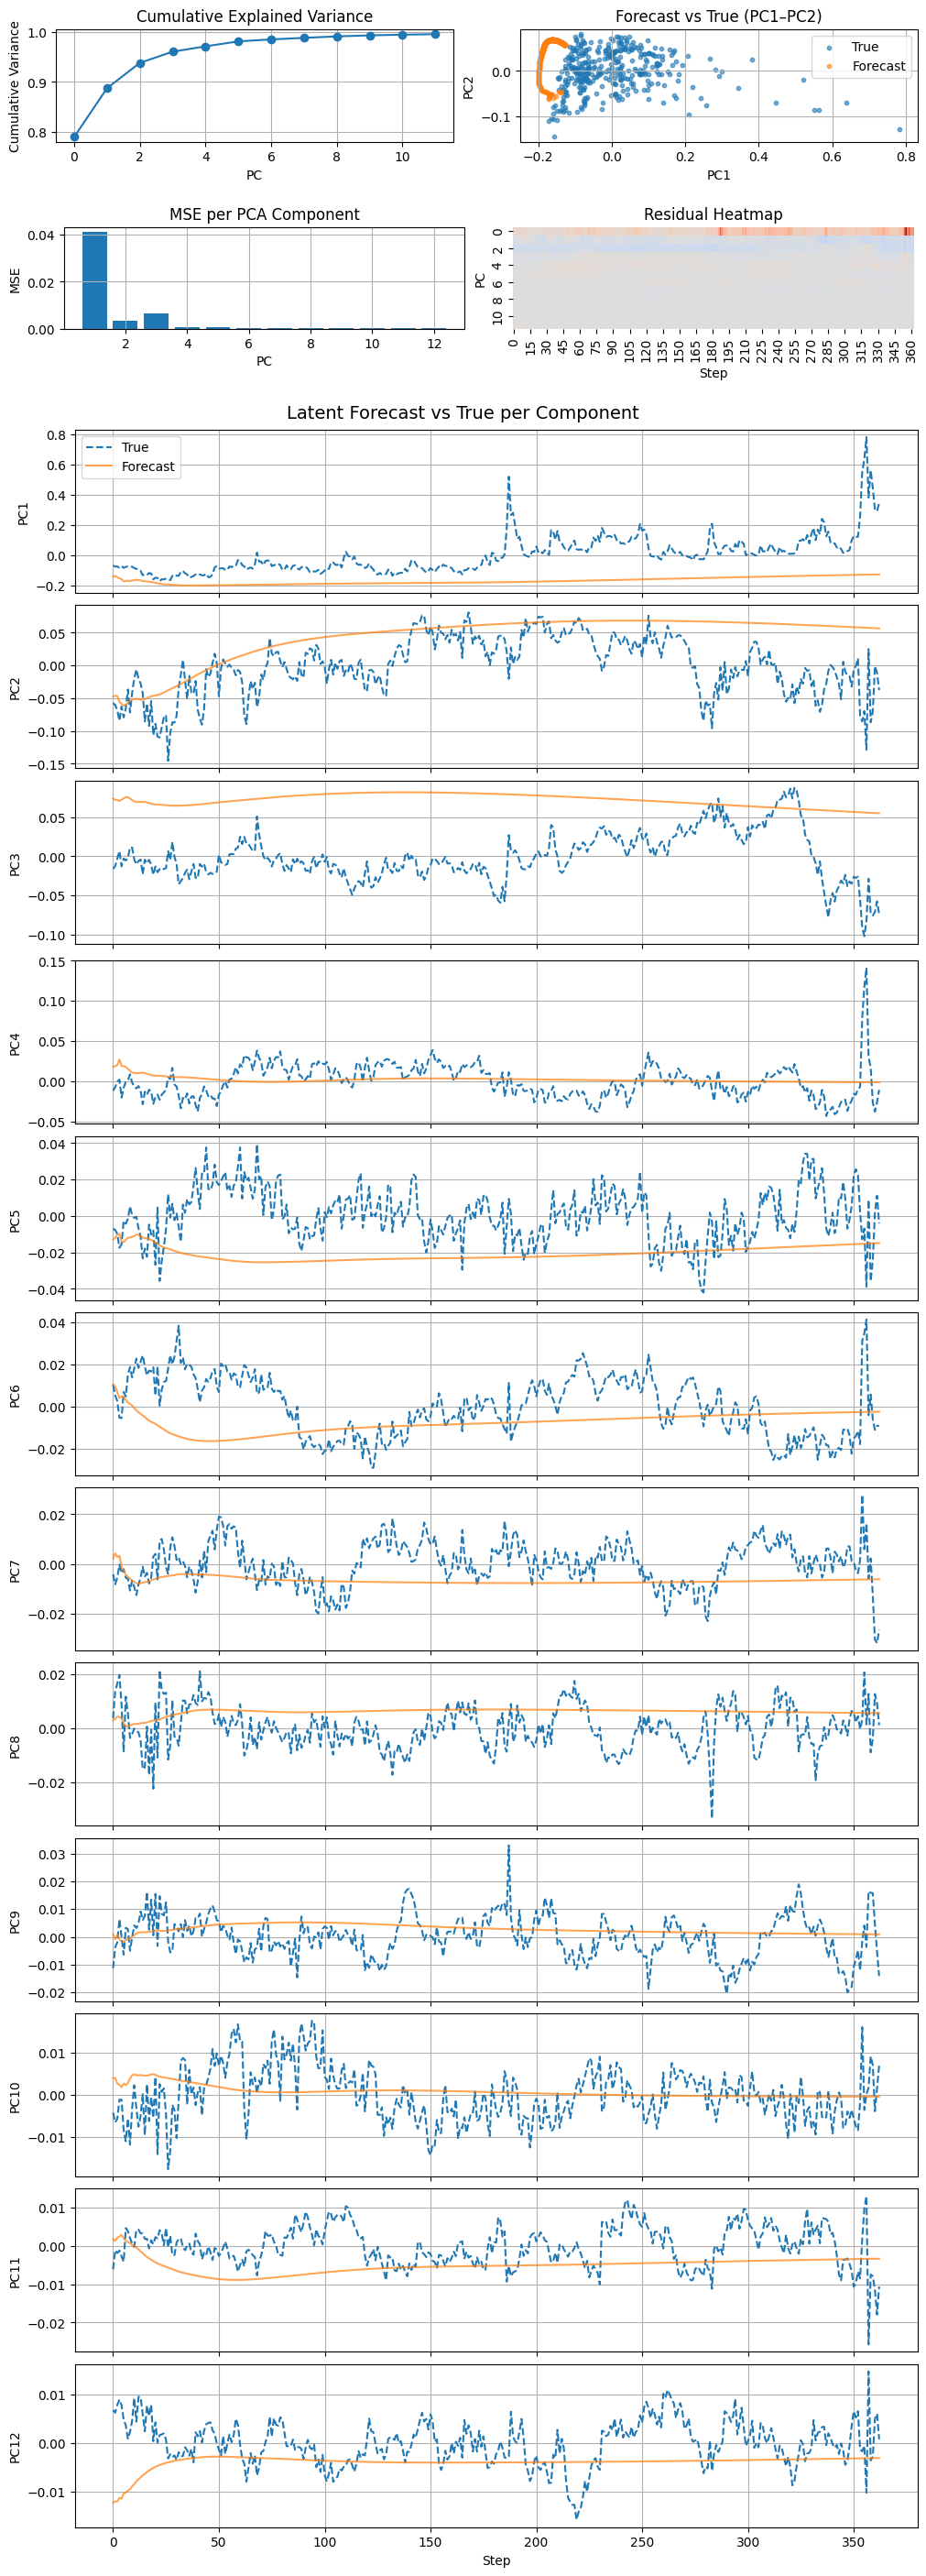

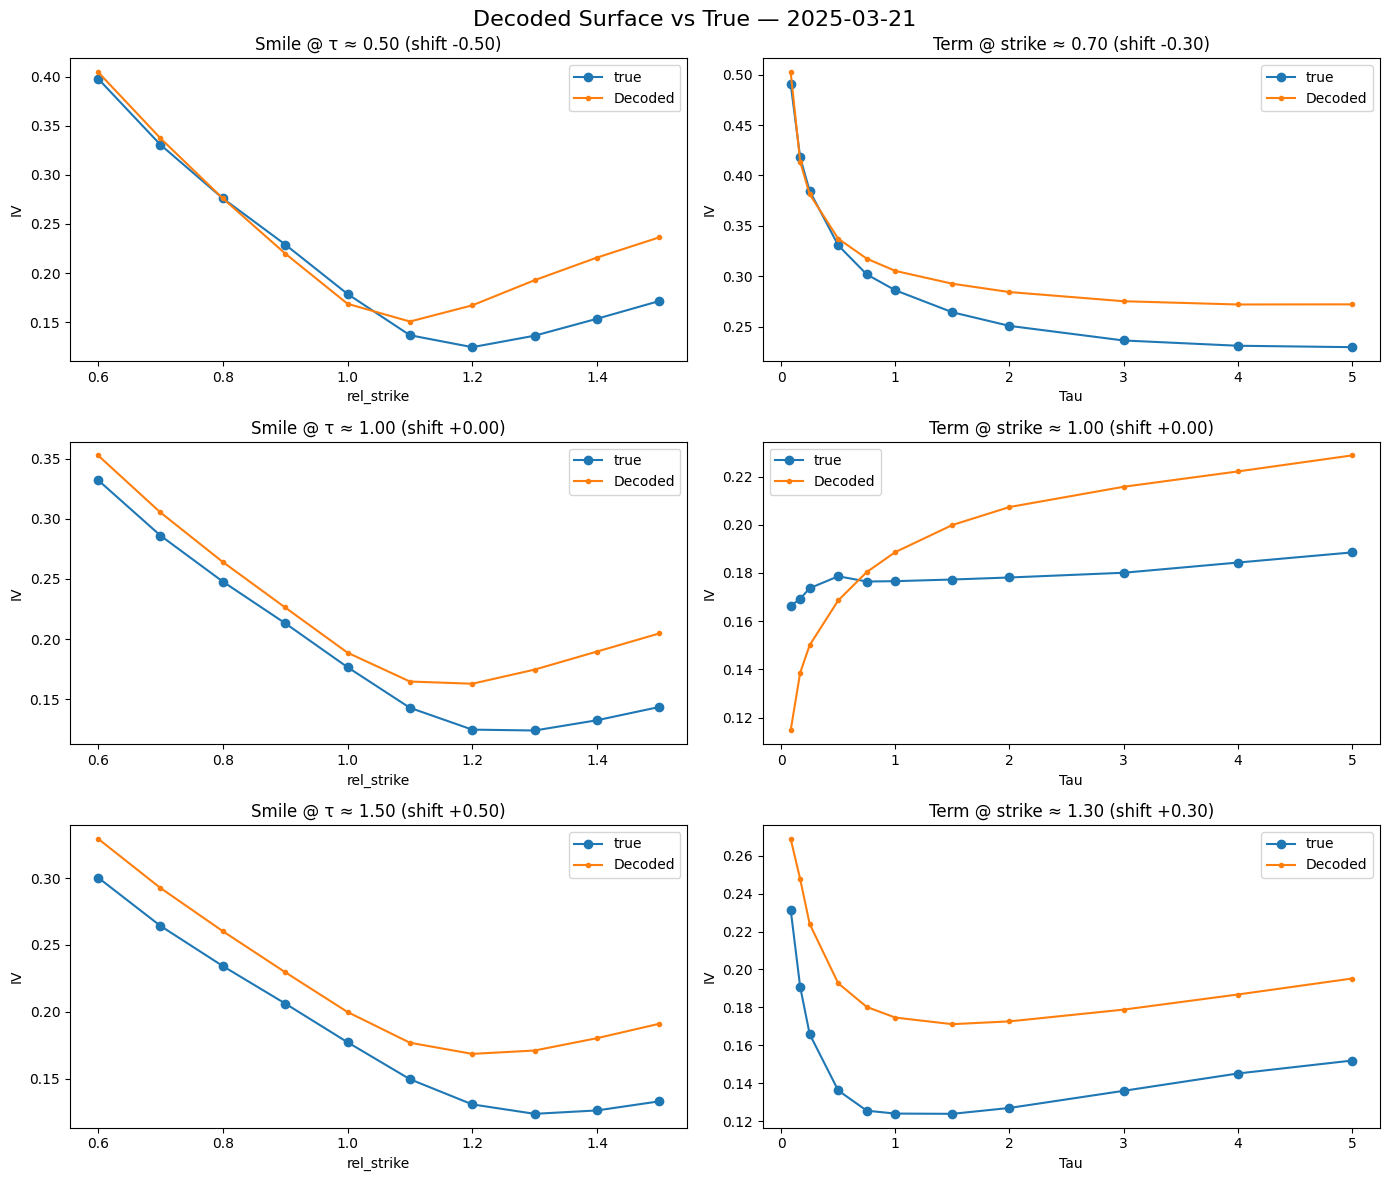

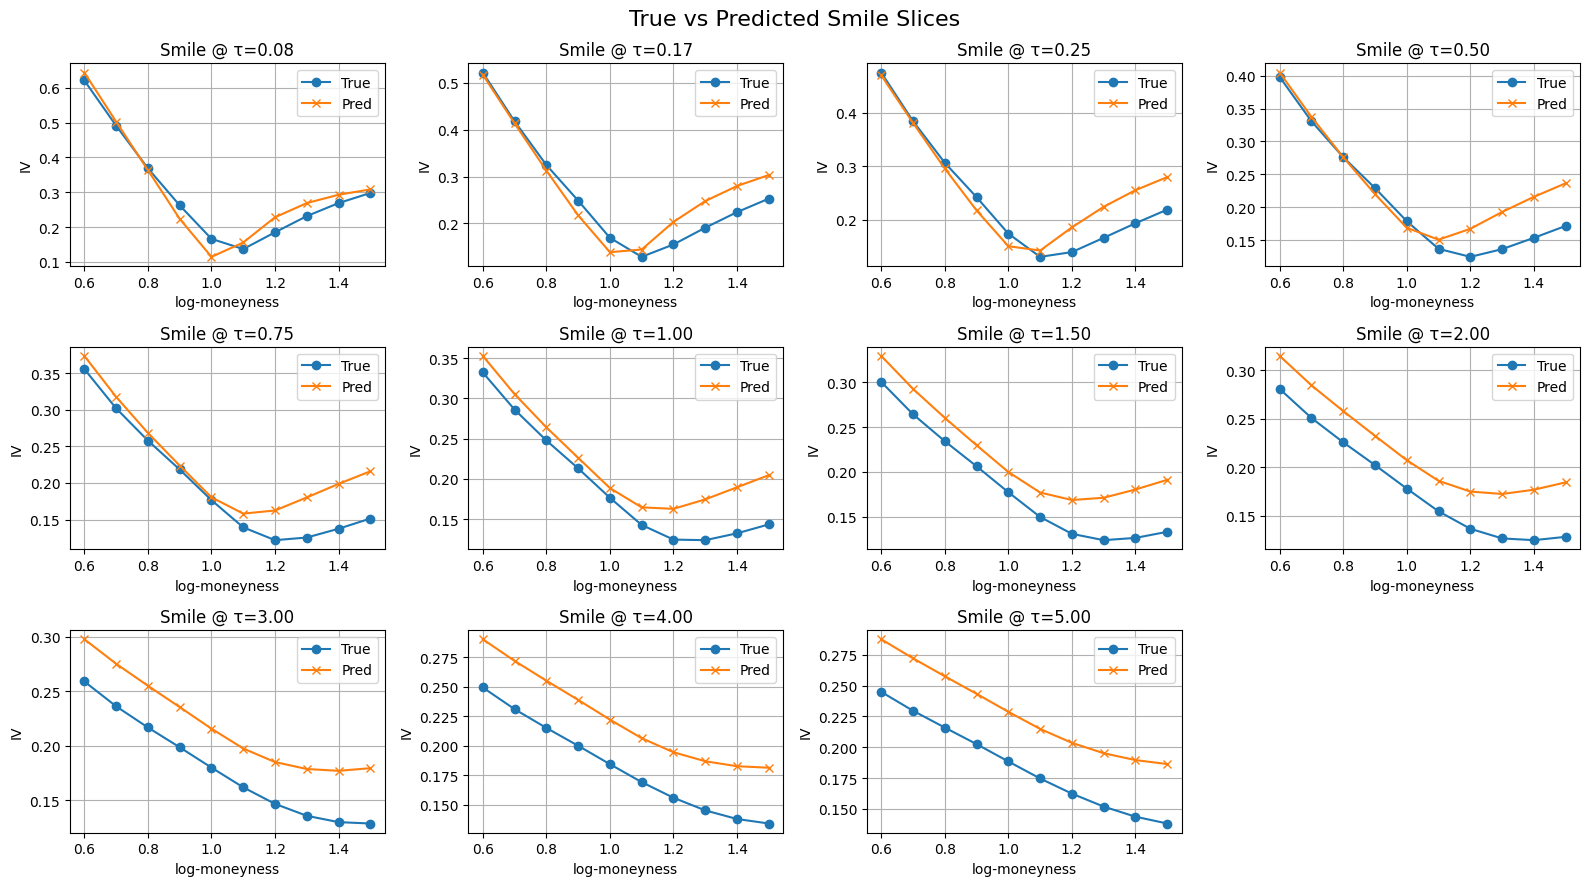

In [8]:
from sklearn.metrics import root_mean_squared_error
from utils.eval import evaluate_pca_var2
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison
from models.forecaster_var import run_pca_var_forecast_with_features

#  inputs
X = pivot_df.values  # shape (T, M*K)
print("X shape (T, M*K):", X.shape)

# Train/test split (use .copy() to prevent downstream mutation)
T = len(X)
T_train = int(0.7 * T)
X_train = X[:T_train].copy()
X_test = X[T_train:].copy()
X_test_raw = X[T_train:].copy()  # keep a pristine version for plotting

#  Extract aligned features
F = features_df.values
min_train_len = min(X_train.shape[0], F.shape[0])
F_train = F[:min_train_len]
F_test = F[min_train_len:]

#  Run full forecasting pipeline with features
Z_forecast, Z_test, Z_train, X_recon, X_true, metrics, pca_out, var_model, X_mean = run_pca_var_forecast_with_features(
    X_train[:min_train_len], X_test[:len(F_test)],
    F_train=F_train,
    F_test=F_test,
    latent_dim=LATENT_DIM,
    use_delta=False,
    standardize=False,
    demean_surface=True,
    mean_mode="global",
)

# evaluation 
print("RMSE (surface):", root_mean_squared_error(X_true, X_recon))
evaluate_pca_var2(
    pca=pca_out.pca,
    Z_train=Z_train,
    Z_test=Z_test,
    Z_pred=Z_forecast,
    n_components=LATENT_DIM
)

# plots
true_surface_t = X_test_raw[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=taus,
    rel_strikes=rel_strikes,
    decoded_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE
)

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=rel_strikes,
    taus=taus
)


x shape (t, m*k): (1289, 110)
using mean_mode='predicted' for demeaning: 0.1997
rmse_z: 0.0266 | rmse_σ: 0.2339
rmse (surface): 0.233869


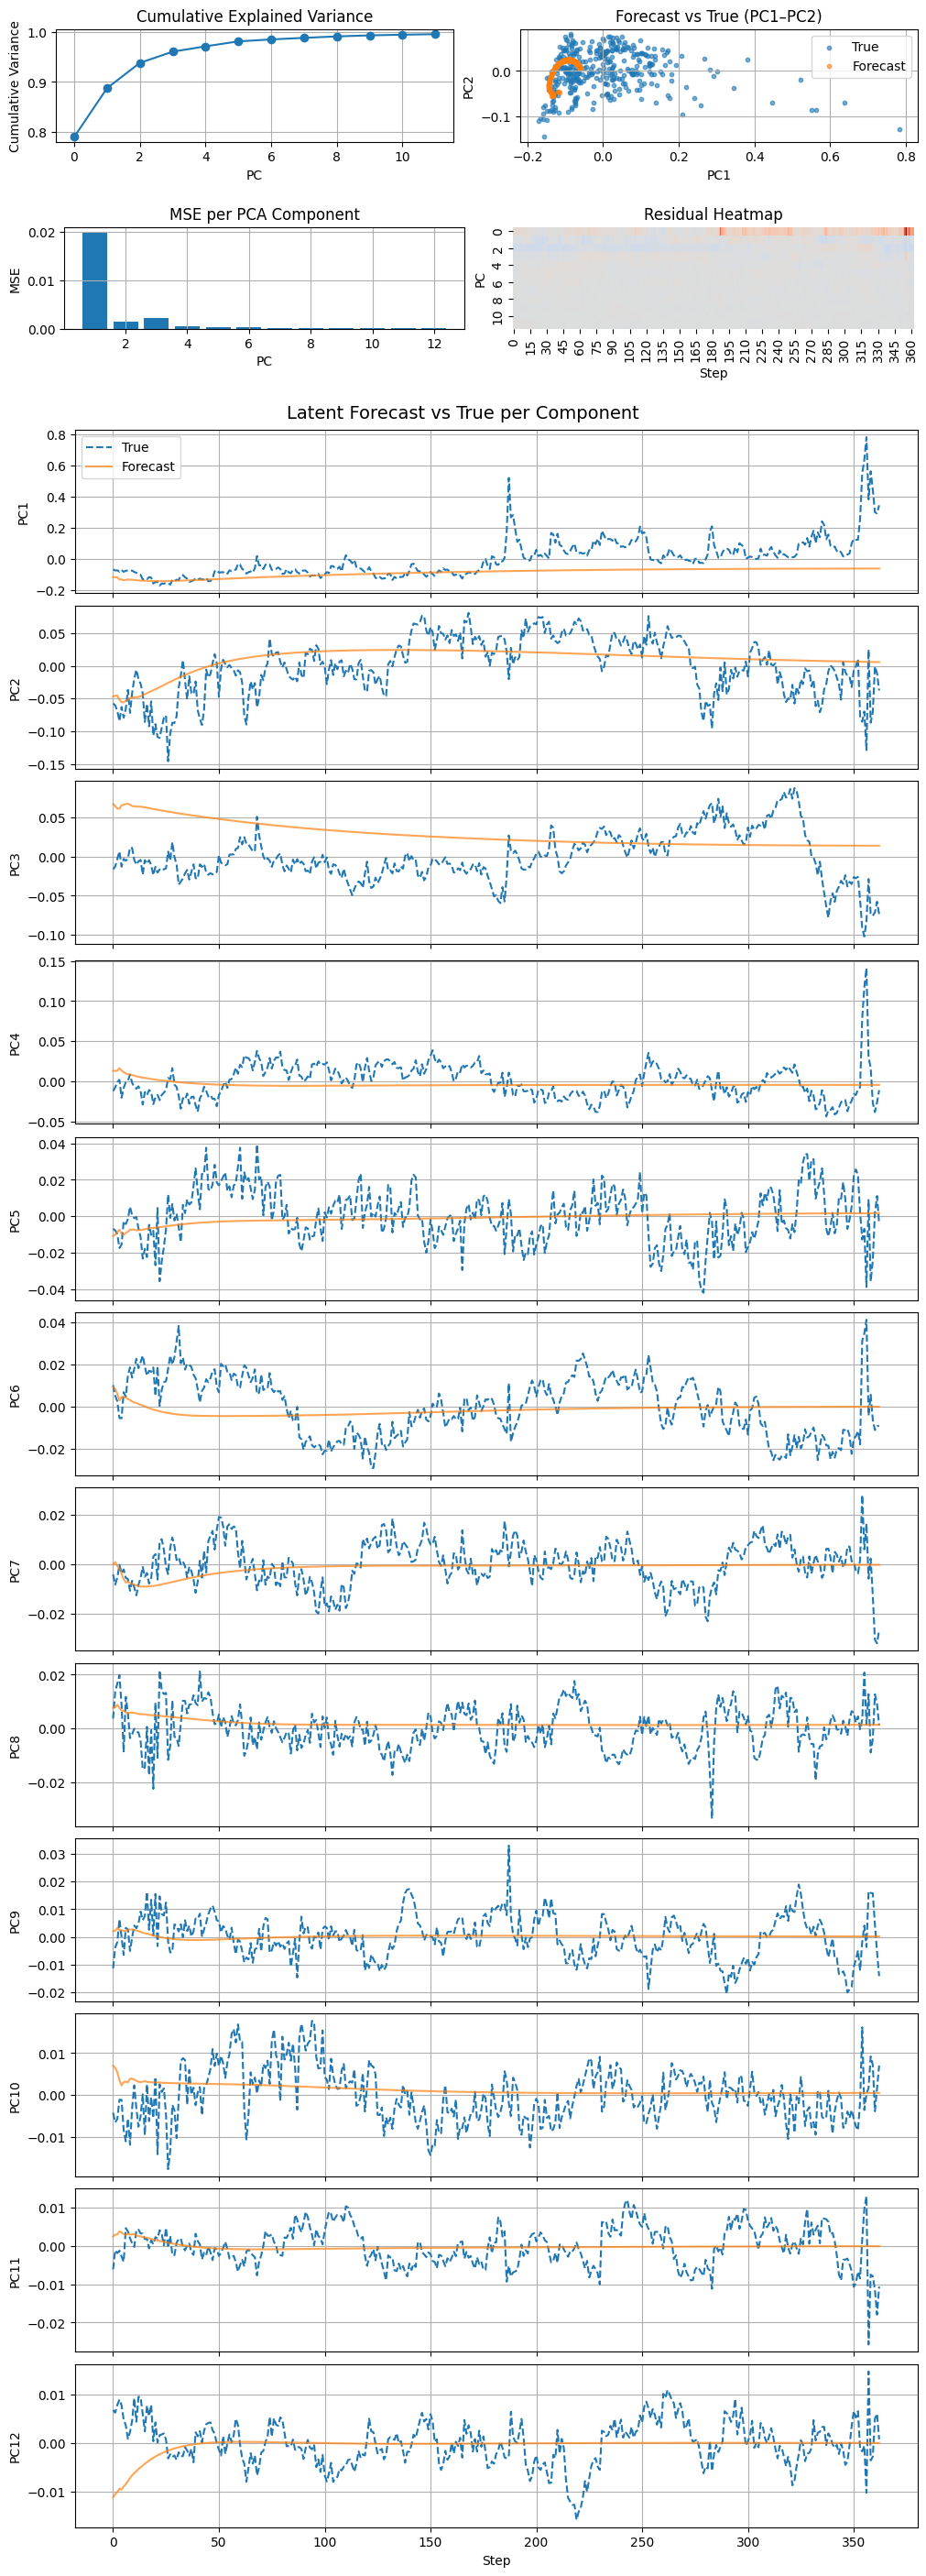

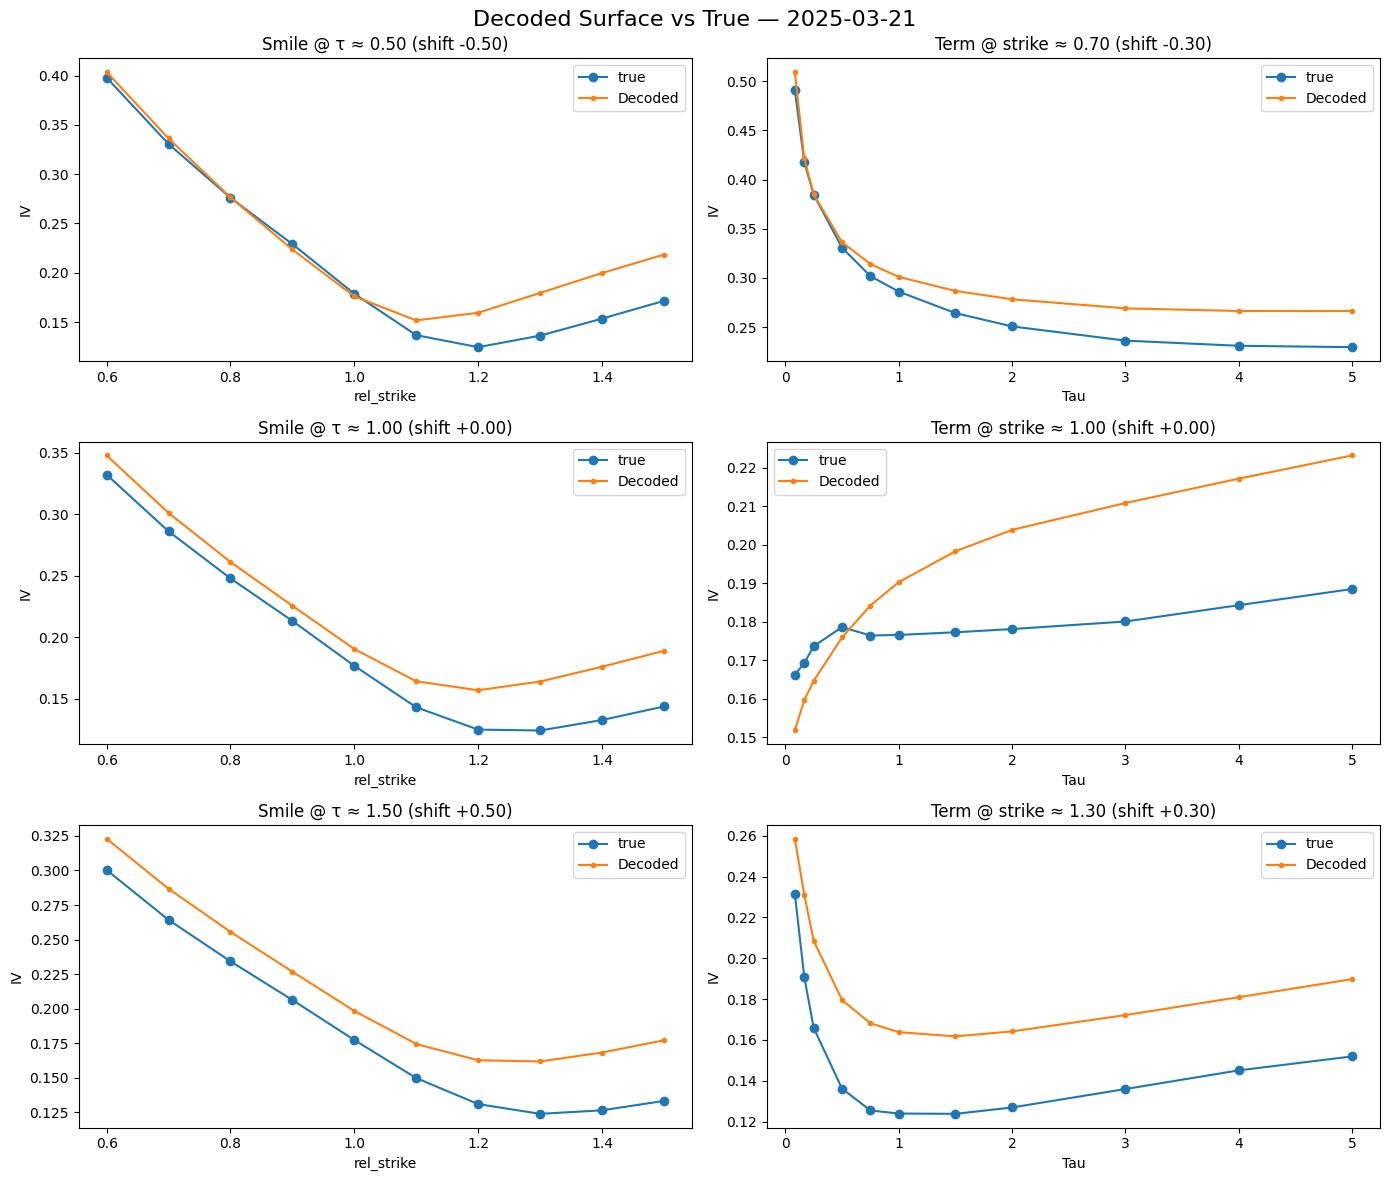

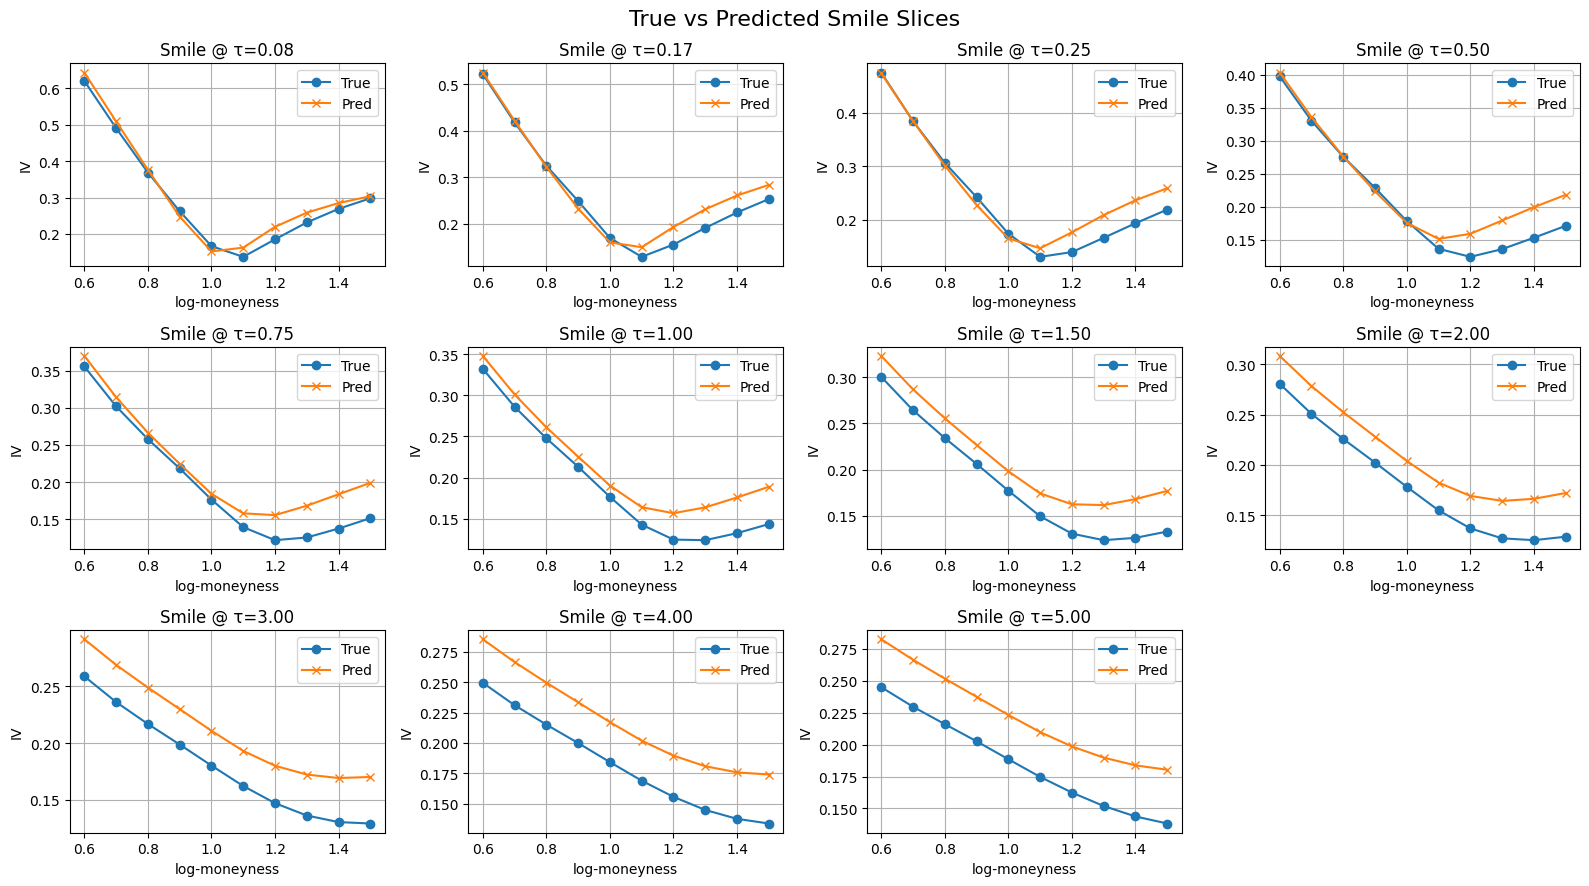

In [9]:
from sklearn.metrics import root_mean_squared_error
from utils.eval import evaluate_pca_var2
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison
from models.forecaster_var import run_pca_var_forecast_with_features

# create inputs
X = pivot_df.values
print(f"x shape (t, m*k): {X.shape}")

# train/test split
T = len(X)
T_train = int(0.7 * T)
X_train = X[:T_train].copy()
X_test = X[T_train:].copy()
X_test_raw = X[T_train:].copy()  # pristine for plotting

# subset of aligned features
F_subset = features_df[["log_return", "smile_skew", "ts_slope"]].copy().dropna()
F_subset = F_subset.loc[F_subset.index.intersection(pivot_df.index)]
F = F_subset.values

# align x and f
min_train_len = min(X_train.shape[0], F.shape[0])
F_train = F[:min_train_len]
F_test = F[min_train_len:]
X_train = X_train[:min_train_len]
X_test = X_test[:len(F_test)]

# run pipeline with subset of features
Z_forecast, Z_test, Z_train, X_recon, X_true, metrics, pca_out, var_model, X_mean = run_pca_var_forecast_with_features(
   X_train, X_test,
   F_train=F_train,
   F_test=F_test,
   latent_dim=LATENT_DIM,
   use_delta=False,
   standardize=False,
   demean_surface=True,
   mean_mode="predicted",
)

# evaluate
print(f"rmse (surface): {root_mean_squared_error(X_true, X_recon):.6f}")
evaluate_pca_var2(
   pca=pca_out.pca,
   Z_train=Z_train,
   Z_test=Z_test,
   Z_pred=Z_forecast,
   n_components=LATENT_DIM
)

# plot final surface
true_surface_t = X_test_raw[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=taus,
   rel_strikes=rel_strikes,
   decoded_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=rel_strikes,
   taus=taus
)

using mean_mode='predicted' for demeaning: 0.1997
rmse_z: 0.0265 | rmse_σ: 0.2341
using mean_mode='predicted' for demeaning: 0.1931
rmse_z: 0.0377 | rmse_σ: 0.2280
using mean_mode='predicted' for demeaning: 0.1931
rmse_z: 0.0273 | rmse_σ: 0.2278
‖z2 - z3‖: 1.9102
‖z2[:, 0] - z3[:, 0]‖: 0.8010
             model    rmse_z    rmse_σ
0     surface only  0.026534  0.234089
1     all features  0.037716  0.227980
2  subset features  0.027328  0.227763


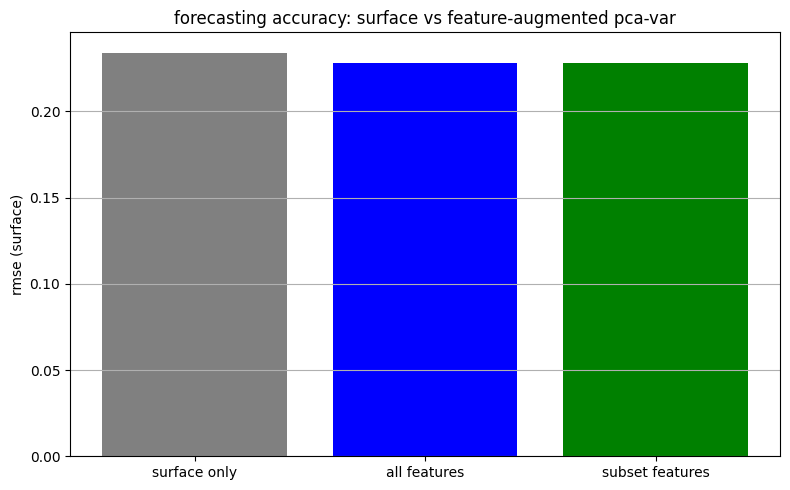

In [10]:
from models.forecaster_var import run_pca_var_forecast, run_pca_var_forecast_with_features
import pandas as pd
import matplotlib.pyplot as plt

# surface-only input
X1 = pivot_df.dropna().values
T1 = len(X1)
T_train1 = int(0.7 * T1)
X_train1, X_test1 = X1[:T_train1], X1[T_train1:]

# all features input
common_all = features_df.dropna().index.intersection(pivot_df.dropna().index)
X2 = pivot_df.loc[common_all].values
F2 = features_df.loc[common_all].values
T2 = len(X2)
T_train2 = int(0.7 * T2)
X_train2, X_test2 = X2[:T_train2], X2[T_train2:]
F_train2, F_test2 = F2[:T_train2], F2[T_train2:]

# subset features input
subset_cols = ["log_return", "smile_skew", "ts_slope"]
subset_df = features_df[subset_cols].dropna()
common_sub = subset_df.index.intersection(pivot_df.dropna().index)
X3 = pivot_df.loc[common_sub].values
F3 = subset_df.loc[common_sub].values
T3 = len(X3)
T_train3 = int(0.7 * T3)
X_train3, X_test3 = X3[:T_train3], X3[T_train3:]
F_train3, F_test3 = F3[:T_train3], F3[T_train3:]

# run all three variants
Z1, _, _, _, _, (rmse_z1, rmse_s1), _, _, _ = run_pca_var_forecast(
   X_train1, X_test1,
   latent_dim=LATENT_DIM,
   use_delta=False,
   demean_surface=True,
   mean_mode="predicted"
)

Z2, _, _, _, _, (rmse_z2, rmse_s2), _, _, _ = run_pca_var_forecast_with_features(
   X_train2, X_test2,
   F_train=F_train2, F_test=F_test2,
   latent_dim=LATENT_DIM,
   use_delta=False,
   demean_surface=True,
   mean_mode="predicted"
)

Z3, _, _, _, _, (rmse_z3, rmse_s3), _, _, _ = run_pca_var_forecast_with_features(
   X_train3, X_test3,
   F_train=F_train3, F_test=F_test3,
   latent_dim=LATENT_DIM,
   use_delta=False,
   demean_surface=True,
   mean_mode="predicted"
)

print(f"‖z2 - z3‖: {np.linalg.norm(Z2 - Z3):.4f}")
print(f"‖z2[:, 0] - z3[:, 0]‖: {np.linalg.norm(Z2[:, 0] - Z3[:, 0]):.4f}")

# summarize
df_cmp = pd.DataFrame({
   "model": ["surface only", "all features", "subset features"],
   "rmse_z": [rmse_z1, rmse_z2, rmse_z3],
   "rmse_σ": [rmse_s1, rmse_s2, rmse_s3]
})
print(df_cmp)

plt.figure(figsize=(8, 5))
plt.bar(df_cmp["model"], df_cmp["rmse_σ"], color=["gray", "blue", "green"])
plt.ylabel("rmse (surface)")
plt.title("forecasting accuracy: surface vs feature-augmented pca-var")
plt.grid(axis="y")
plt.tight_layout()
plt.show()



We tested three variants of the PCA–VAR surface forecasting pipeline:

- **Surface only**: baseline model using historical implied volatility surfaces only.
- **All features**: included macroeconomic, smile, term structure, and yield curve features.
- **Subset features**: included only log-returns, smile skew, and term slope.

Despite meaningful differences in the latent forecasts `Z_forecast` (e.g., ‖Z₂−Z₃‖ ≈ 1.13), the decoded surfaces `X_recon` exhibit nearly identical surface RMSE across all variants. This suggests:

- The current **PCA decoder is not sensitive enough** to variations in the latent space.
- The decoder likely concentrates expressivity in the first 1–2 principal components.
- The feature space, as currently defined, **does not enhance surface-level predictions**, despite influencing latent trajectories.

---

#### Implications

This leads us to two conclusions:

1. **Feature augmentation requires refinement**: we may need better time-aligned, derivative-based, or regime-aware features to influence surface dynamics effectively.
2. **Decoder methodology must evolve**: we should explore:
   - **Pointwise or slice-wise PCA** to increase spatial resolution
   - **Nonlinear decoders (VAE, neural)** to better express local sensitivity

These adjustments will guide the next stage of the pipeline, moving us closer to the full architecture outlined in the milestone roadmap.


---

---

In [11]:


from data.tensor_builder import build_vol_tensors
from keras import ops

maturity_to_tau = {
    '1m': 1/12, '2m': 2/12, '3m': 3/12, '6m': 0.5, '9m': 0.75,
    '1y': 1.0, '18m': 1.5, '2y': 2.0, '3y': 3.0, '4y': 4.0, '5y': 5.0
}

tensors = build_vol_tensors(df, maturity_to_tau)

surface_tensor = tensors["surface_tensor"]
spot_tensor = tensors["spot_tensor"]
curve_tensor = tensors["curve_tensor"]
date_tensor = tensors["date_tensor"]
strike_tensor = tensors["strike_tensor"]
abs_strike_tensor = tensors["abs_strike_tensor"]
ssvi_tensor = tensors["ssvi_tensor"]
heston_tensor = tensors["heston_tensor"]



print(" Tensors built successfully")
print("date_tensor:", date_tensor.shape)
print("strike_tensor (rel):", ops.shape(strike_tensor))
print("abs_strike_tensor:", ops.shape(abs_strike_tensor))
print("spot_tensor:", ops.shape(spot_tensor))
print("curve_tensor:", ops.shape(curve_tensor))
print("surface_tensor:", ops.shape(surface_tensor))
print("ssvi_tensor:", ops.shape(ssvi_tensor))
print("heston_tensor:", ops.shape(heston_tensor))
print("All tensors have been built and are ready for use.")

 Tensors built successfully
date_tensor: (1282,)
strike_tensor (rel): (10,)
abs_strike_tensor: (1282, 10)
spot_tensor: (1282,)
curve_tensor: (1282, 32)
surface_tensor: (1282, 11, 10, 6)
ssvi_tensor: (1282, 11, 10, 3)
heston_tensor: (1282, 11, 5)
All tensors have been built and are ready for use.


surface-only pca-var rmse_σ: 0.0003
reconstruction max: 0.6751
true max: 0.9423
rmse (surface): 0.0153


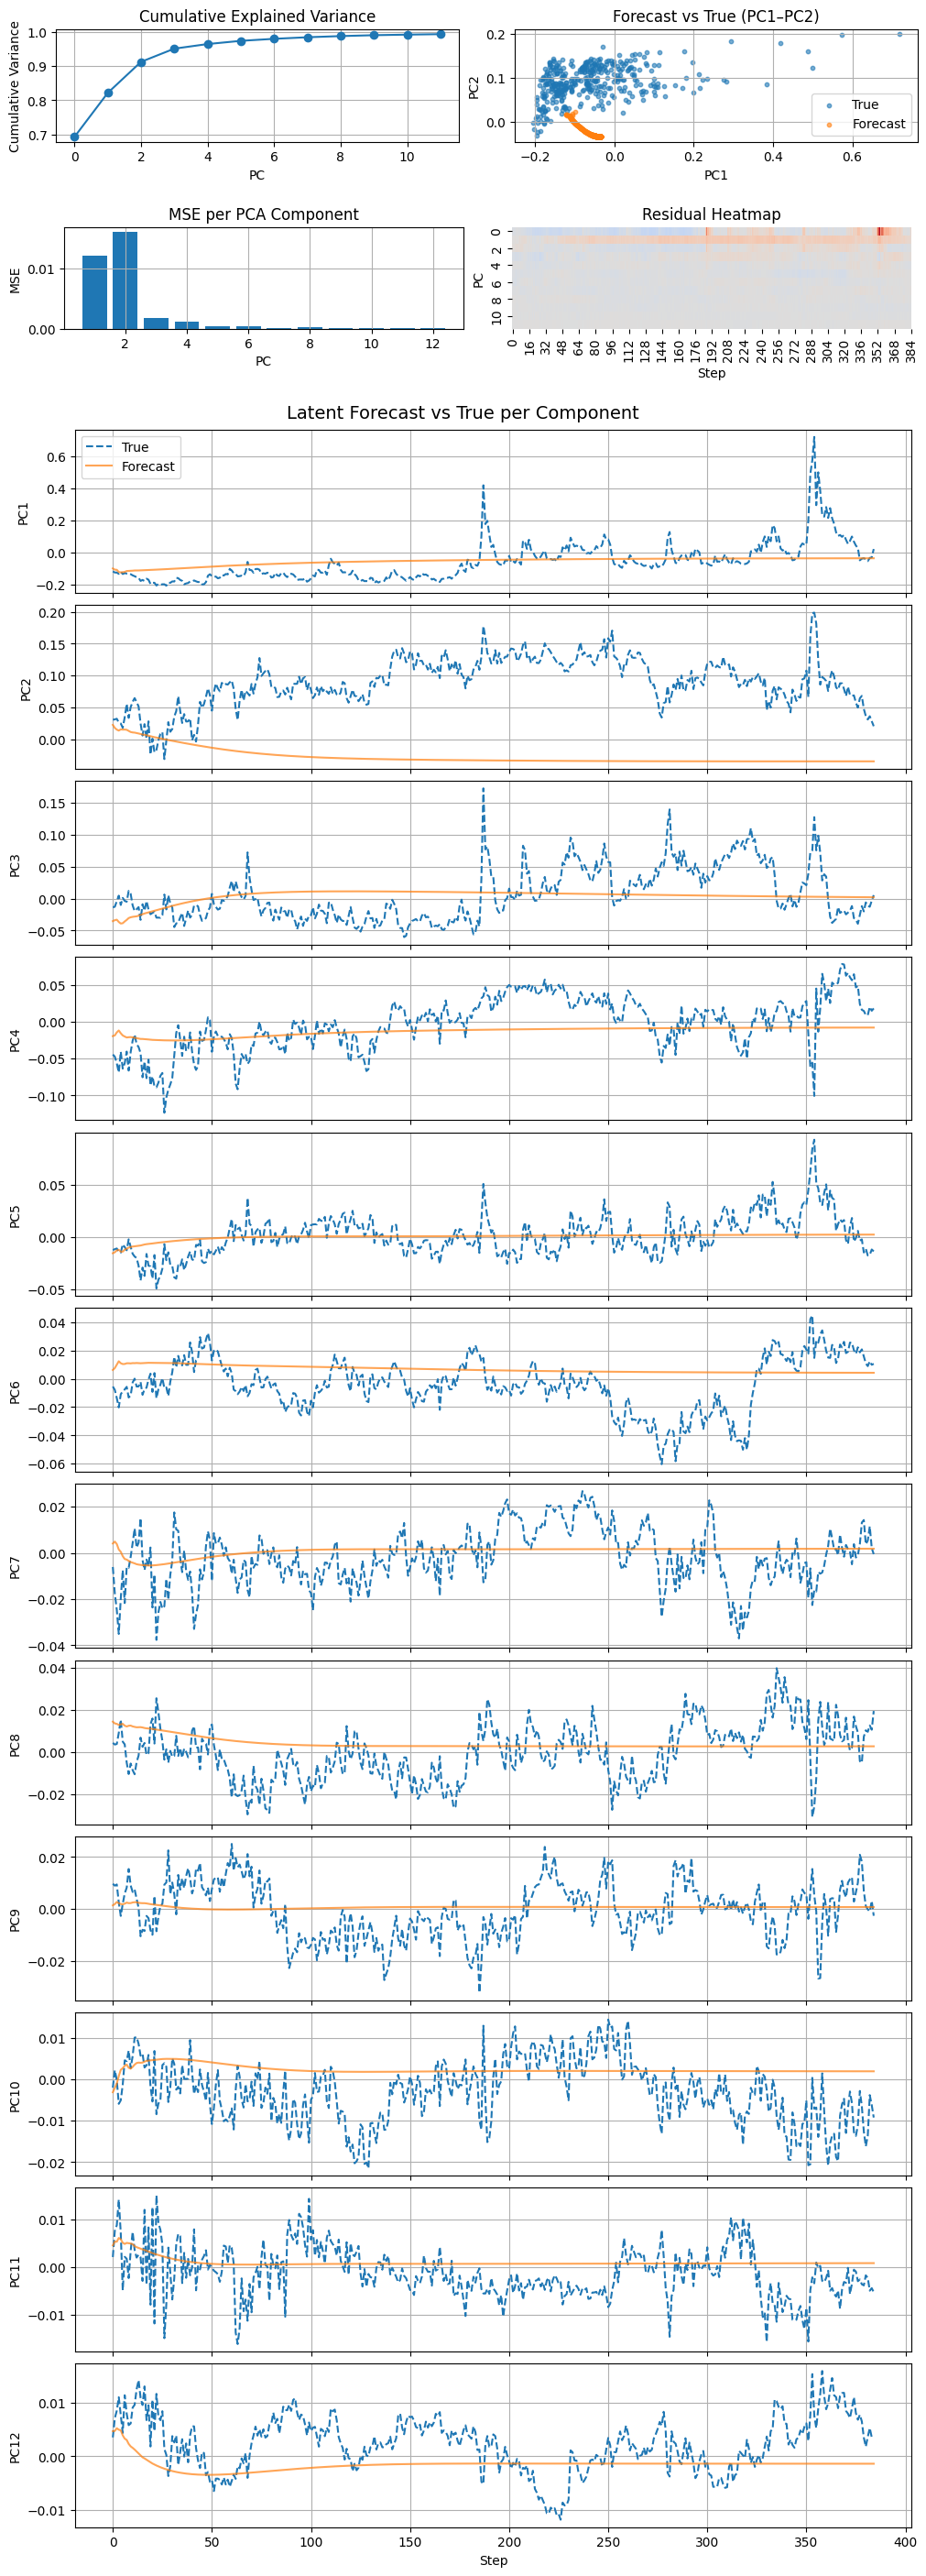

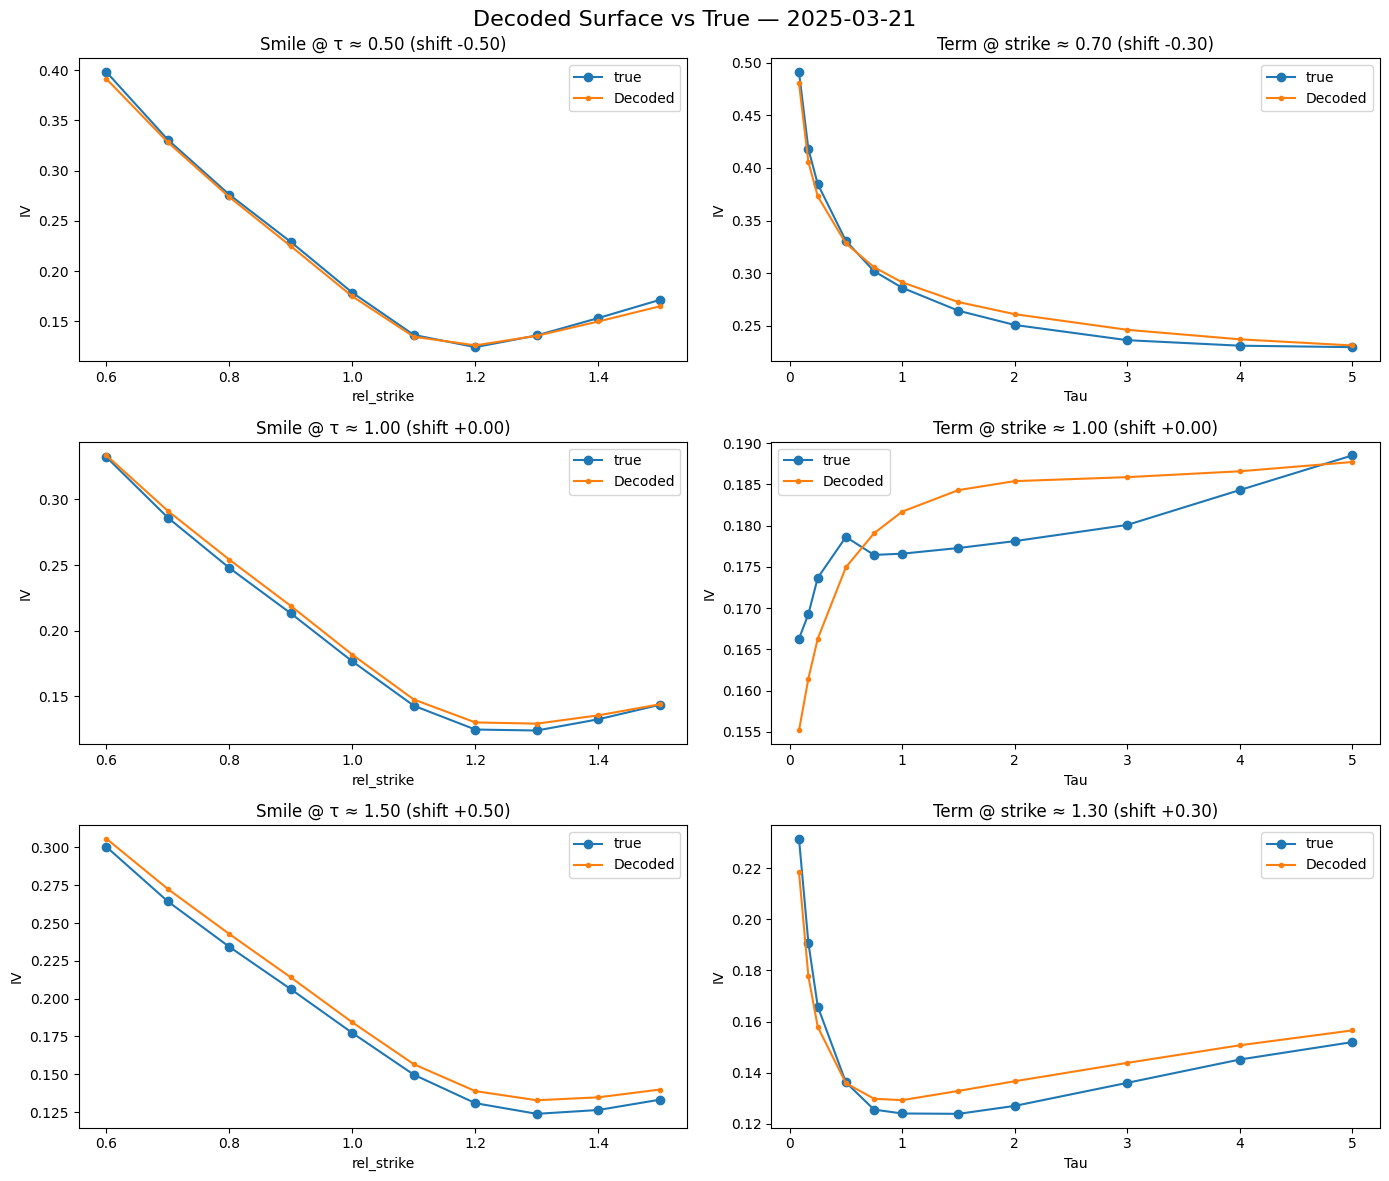

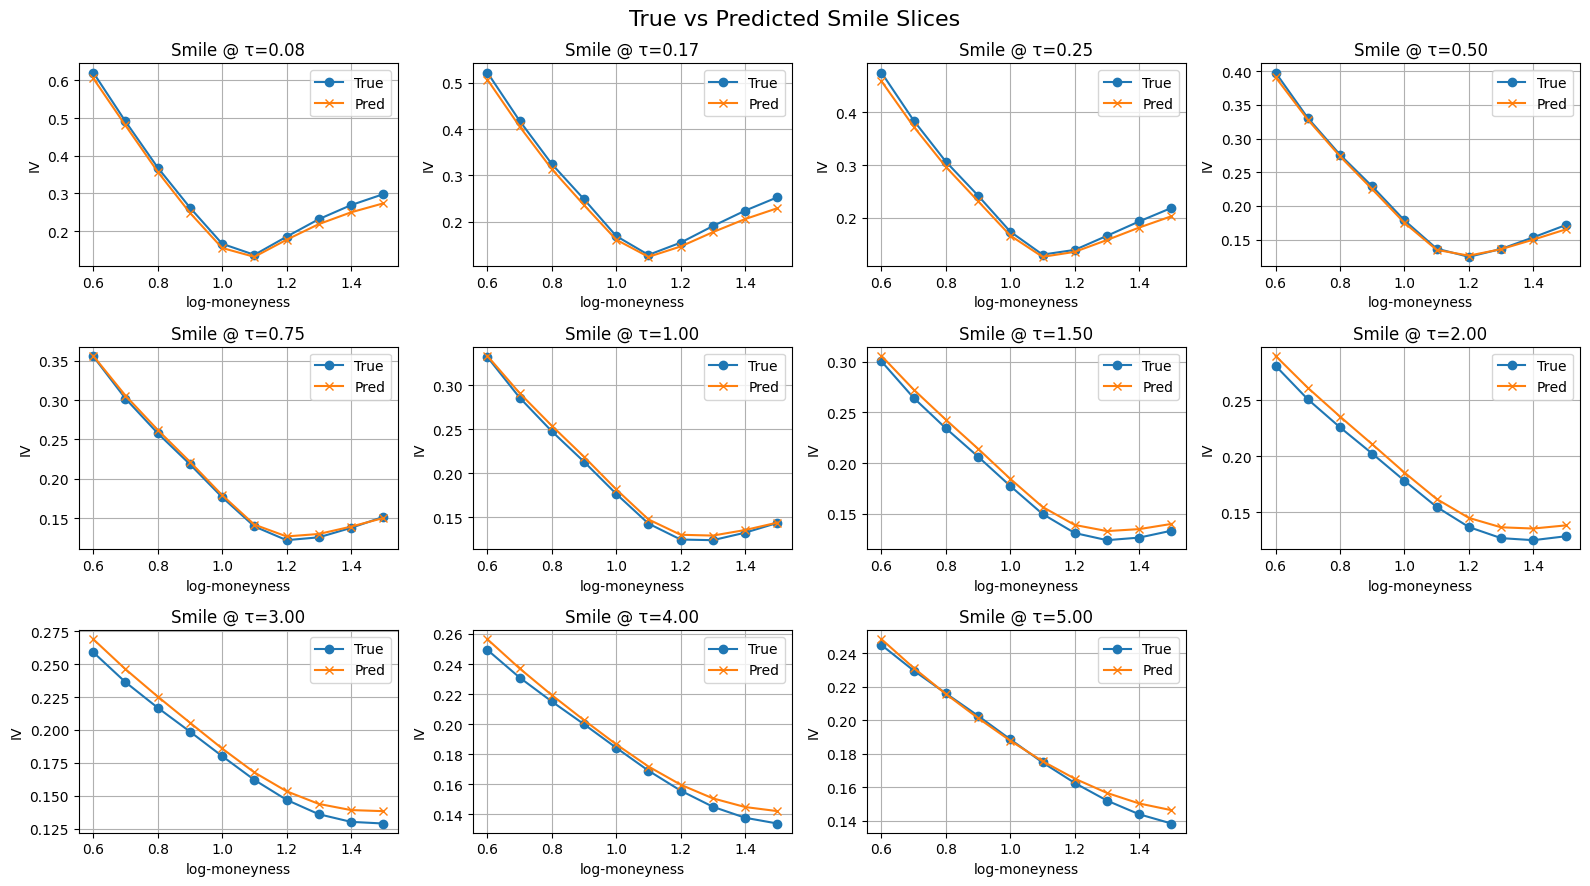

In [12]:
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from utils.eval import evaluate_pca_var2
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison
from keras import ops
import numpy as np

# flatten and convert surface tensor: (t, m*k)
iv_surface = ops.convert_to_numpy(surface_tensor)[..., -1]
T, M, K = iv_surface.shape
X_grid = iv_surface.reshape(T, M * K).astype(np.float64)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# pca across surfaces
pca = PCA(n_components=LATENT_DIM)
Z_all = pca.fit_transform(X_demeaned)

# split
T_train = int(0.7 * T)
Z_train, Z_test = Z_all[:T_train], Z_all[T_train:]
X_mean_forecast = X_mean[T_train:T]

# var on latent
var_model = VAR(Z_train)
var_results = var_model.fit(maxlags=5)
Z_forecast = var_results.forecast(Z_train[-var_results.k_ar:], steps=len(Z_test))

# decode and add back mean
X_recon_demeaned = pca.inverse_transform(Z_forecast)
X_recon = X_recon_demeaned + X_mean_forecast
X_true = X_grid[T_train:T_train + len(X_recon)]

# reshape for rmse and plots
X_recon = X_recon.reshape(-1, M, K)
X_true = X_true.reshape(-1, M, K)

# rmse and diagnostics
X_true_flat = X_true.reshape(X_true.shape[0], -1)
X_recon_flat = X_recon.reshape(X_recon.shape[0], -1)
rmse_surface = mean_squared_error(X_true_flat, X_recon_flat)
print(f"surface-only pca-var rmse_σ: {rmse_surface:.4f}")
print(f"reconstruction max: {np.abs(X_recon).max():.4f}")
print(f"true max: {np.abs(X_true).max():.4f}")

print(f"rmse (surface): {root_mean_squared_error(X_true_flat, X_recon_flat):.4f}")
evaluate_pca_var2(
   pca=pca,
   Z_train=Z_train,
   Z_test=Z_test,
   Z_pred=Z_forecast,
   n_components=LATENT_DIM
)

# visualize last surface
true_surface_t = X_true[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=taus,
   rel_strikes=rel_strikes,
   decoded_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=rel_strikes,
   taus=taus
)

surface-wise pca-var + features rmse_σ: 0.0004
reconstruction max: 0.6505
true max: 0.9423


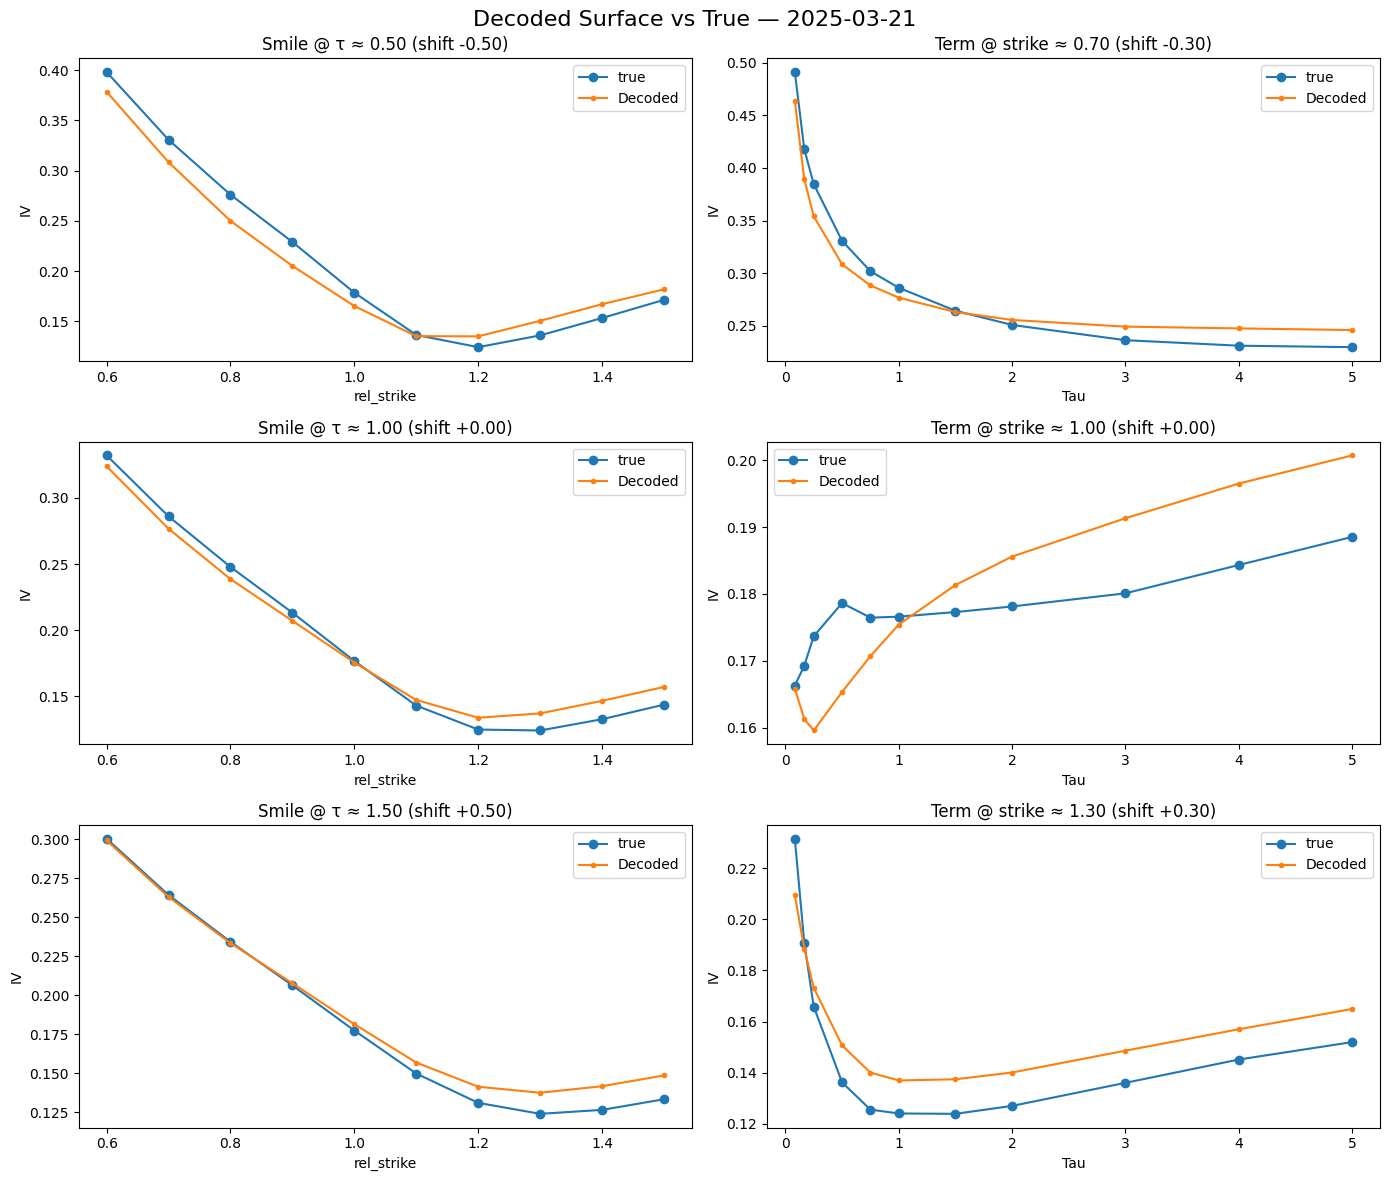

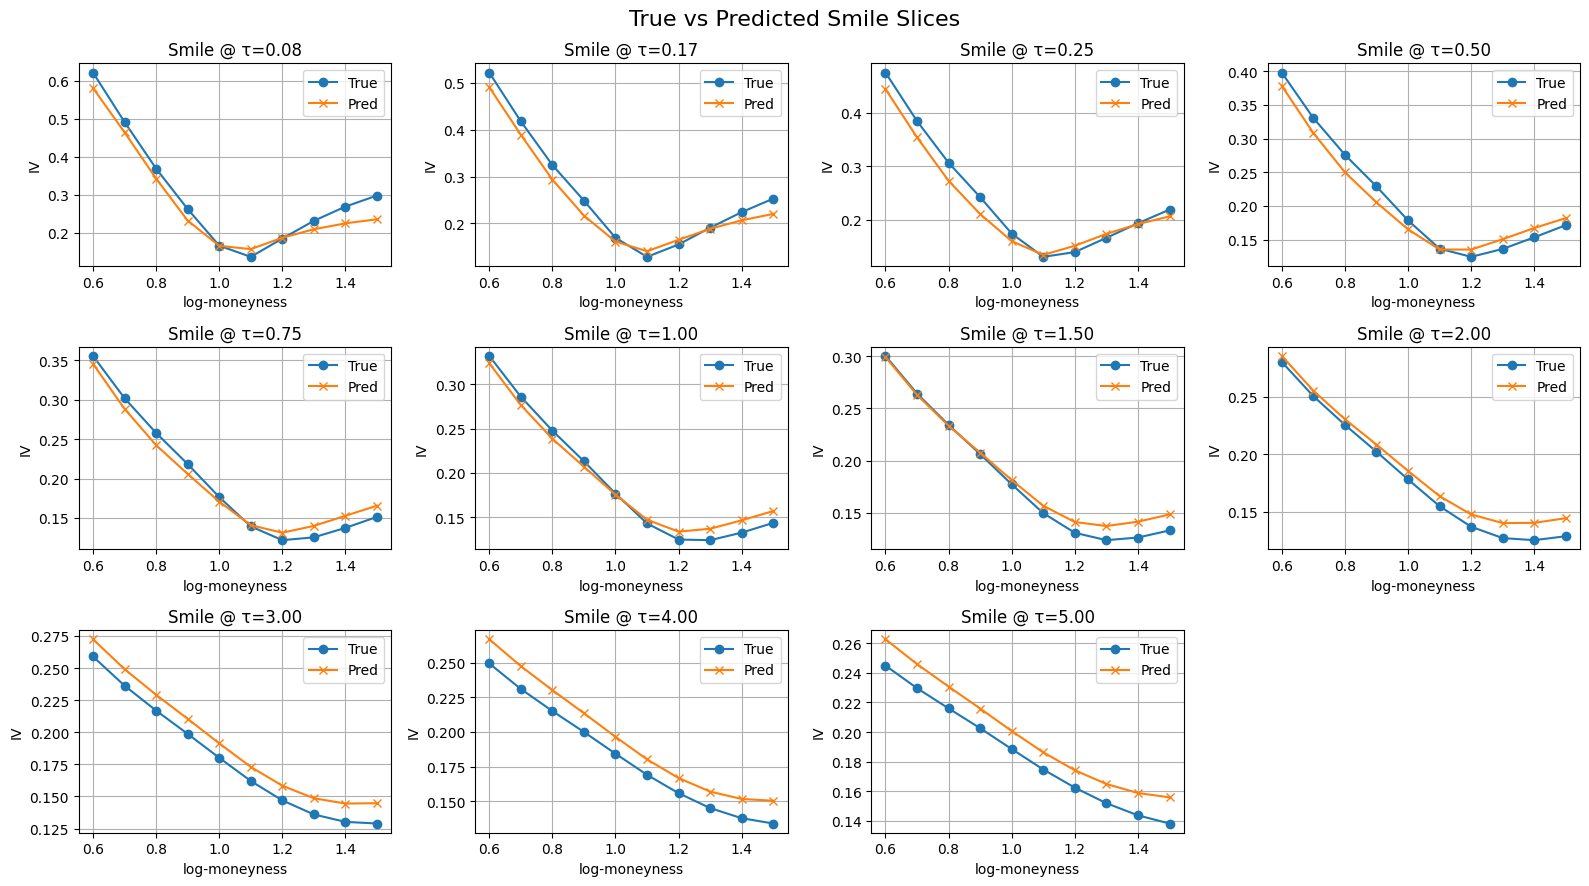

In [13]:
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison
from keras import ops
import numpy as np

# convert tensor and flatten: shape (t, m*k)
iv_surface = ops.convert_to_numpy(surface_tensor)[..., -1]
T, M, K = iv_surface.shape
X_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# feature selection
# option 1: full features
F = features_df.loc[features_df.index.intersection(pivot_df.index)]

# option 2: minimal subset (uncomment to activate)
# F = features_df[["log_return", "smile_skew", "ts_slope"]].dropna()
# F = F.loc[F.index.intersection(pivot_df.index)]

# align surface to feature index
X_df = pivot_df.loc[F.index]
X_grid = X_df.values.astype(np.float64)
F_aligned = F.values
T = len(X_grid)
T_train = int(0.7 * T)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# pca (shared across surfaces)
pca = PCA(n_components=LATENT_DIM)
Z_all = pca.fit_transform(X_demeaned)
Z_aug = np.concatenate([Z_all, F_aligned], axis=1)

# split
Z_train, Z_test = Z_aug[:T_train], Z_aug[T_train:]
Z_train_pure = Z_all[:T_train]

# var on raw z
var_model = VAR(Z_train)
var_results = var_model.fit(maxlags=5)
Z_forecast = var_results.forecast(Z_train[-var_results.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast[:, :LATENT_DIM]

# decode and re-add mean
X_recon_demeaned = pca.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_recon = X_recon_demeaned + X_mean_forecast
X_true = X_grid[T_train:T_train + len(X_recon)]

# reshape for rmse and plotting
X_recon = X_recon.reshape(-1, M, K)
X_true = X_true.reshape(-1, M, K)

# sanity checks
assert not np.isnan(X_recon).any(), "nans in x_recon"
assert not np.isnan(X_true).any(), "nans in x_true"

# rmse
rmse_surface = mean_squared_error(
   X_true.reshape(-1, M * K),
   X_recon.reshape(-1, M * K)
)
print(f"surface-wise pca-var + features rmse_σ: {rmse_surface:.4f}")
print(f"reconstruction max: {np.abs(X_recon).max():.4f}")
print(f"true max: {np.abs(X_true).max():.4f}")

# plot latest surface
true_surface_t = X_true[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=taus,
   rel_strikes=rel_strikes,
   decoded_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=rel_strikes,
   taus=taus
)

feature influence on var latent forecast:
                      var coefficient norm
ts_weighted                    2133.814975
rate_1y                        1840.176000
realized_vol_5d_ma20           1674.275521
rate_2y                        1607.978505
rate_4y                        1076.828712
rate_3y                        1048.501180
slope_5_10                      976.065972
ts_long_avg                     965.140894
rate_5y                         855.111370
rate_0.5y                       834.569037
rate_0.25y                      834.569037
ts_level                        677.680728
ts_split_slope                  550.549278
ts_short_avg                    451.096219
smile_skew                      431.244537
smile_convexity                 430.111699
ts_slope                        288.613112
log_return_ma20                 239.665254
slope_10_30                     232.440687
ts_curvature                    213.137833
rate_10y                        206.663506
rate_30y    

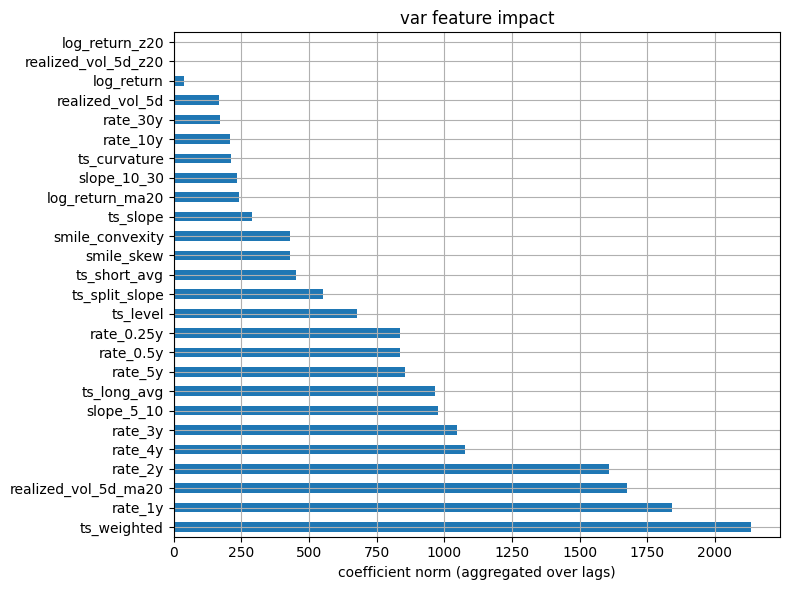

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# get number of lags and input dim
n_lags = var_results.k_ar
n_inputs = Z_train.shape[1]   # latent + features
n_latents = Z_all.shape[1]    # surface pca dims
n_features = F.shape[1]

# strip intercept
coef_matrix = var_results.coefs  # shape: (n_lags, n_latents, n_inputs)

# aggregate influence of each input dim (latent + features)
# compute the frobenius norm of lag coefficients per input dim
influence = np.linalg.norm(coef_matrix, axis=(0, 1))  # shape: (n_inputs,)

# split into latent + features
influence_latents = influence[:n_latents]
influence_features = influence[n_latents:]

# map feature names
feature_names = features_df.columns[-n_features:]  # assumes same alignment
feature_importance = pd.Series(influence_features, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False)

# display
print("feature influence on var latent forecast:")
print(feature_importance.to_frame("var coefficient norm"))

# plot
os.makedirs("../notebooks/saved_images", exist_ok=True)

plt.figure(figsize=(8, 6))
feature_importance.plot(kind="barh")
plt.title("var feature impact")
plt.xlabel("coefficient norm (aggregated over lags)")
plt.grid(True)
plt.tight_layout()
plt.savefig("../notebooks/saved_images/var_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

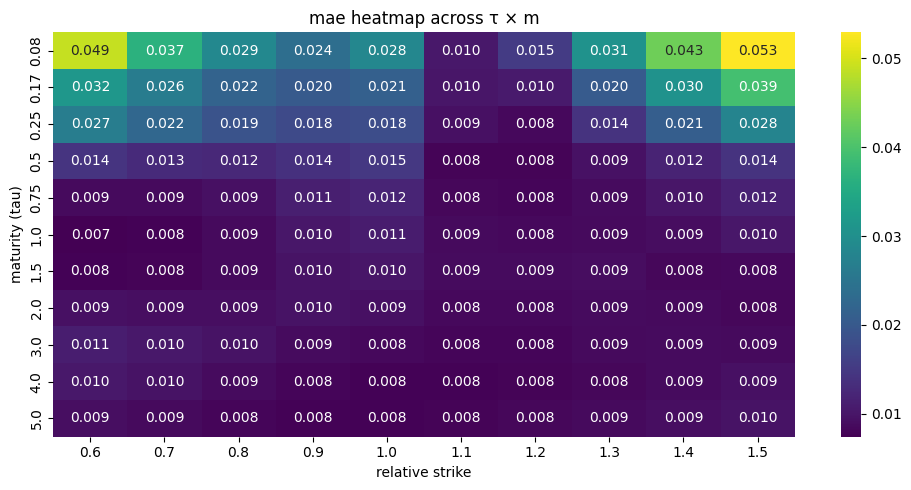

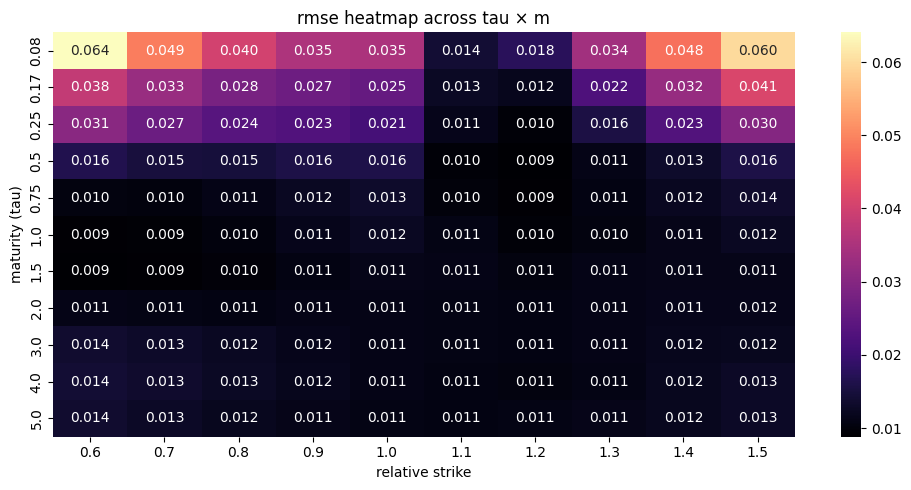

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# flatten errors across time
abs_errors = np.abs(X_recon - X_true)  # shape: (t_test, m, k)
rmse_errors = (X_recon - X_true) ** 2

mae_grid = abs_errors.mean(axis=0)  # shape: (m, k)
rmse_grid = np.sqrt(rmse_errors.mean(axis=0))  # shape: (m, k)

# plot mae
plt.figure(figsize=(10, 5))
sns.heatmap(mae_grid, xticklabels=np.round(rel_strikes, 2), yticklabels=np.round(taus, 2), 
           cmap="viridis", annot=True, fmt=".3f")
plt.title("mae heatmap across τ × m")
plt.xlabel("relative strike")
plt.ylabel("maturity (tau)")
plt.tight_layout()
plt.savefig("../notebooks/saved_images/pca_var_mae_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# plot rmse
plt.figure(figsize=(10, 5))
sns.heatmap(rmse_grid, xticklabels=np.round(rel_strikes, 2), yticklabels=np.round(taus, 2), 
           cmap="magma", annot=True, fmt=".3f")
plt.title("rmse heatmap across tau × m")
plt.xlabel("relative strike")
plt.ylabel("maturity (tau)")
plt.tight_layout()
plt.savefig("../notebooks/saved_images/pca_var_rmse_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def check_no_arbitrage_conditions(surface: np.ndarray, taus: np.ndarray, strikes: np.ndarray):
   """
   surface: shape (M, K) - IV surface at a single time step
   taus: array of length M
   strikes: array of length K
   
   note: this is a simplified check, not the conventional arbitrage test.
   proper calendar arbitrage requires total variance tau*sigma^2 to be increasing,
   not just iv levels. here we only check basic monotonicity as a proxy.
   """
   smile_violations = 0
   calendar_violations = 0
   M, K = surface.shape

   # smile convexity: second derivative should be >= 0
   for i in range(M):
       for j in range(1, K - 1):
           fwd_diff = surface[i, j+1] - surface[i, j]
           back_diff = surface[i, j] - surface[i, j-1]
           if (fwd_diff - back_diff) < 0:
               smile_violations += 1

   # simplified calendar check: iv monotonicity (not proper total variance)
   # proper check would verify tau[i]*iv[i]^2 >= tau[i-1]*iv[i-1]^2
   for j in range(K):
       for i in range(1, M):
           if (surface[i, j] - surface[i-1, j]) < 0:
               calendar_violations += 1

   return smile_violations, calendar_violations

# apply on final reconstructed surface
final_surface = X_recon[-1]
smile_v, cal_v = check_no_arbitrage_conditions(final_surface, np.array(taus), np.array(rel_strikes))

print(f"smile convexity violations: {smile_v}")
print(f"calendar monotonicity violations (simplified): {cal_v}")


smile convexity violations: 16
calendar monotonicity violations (simplified): 58


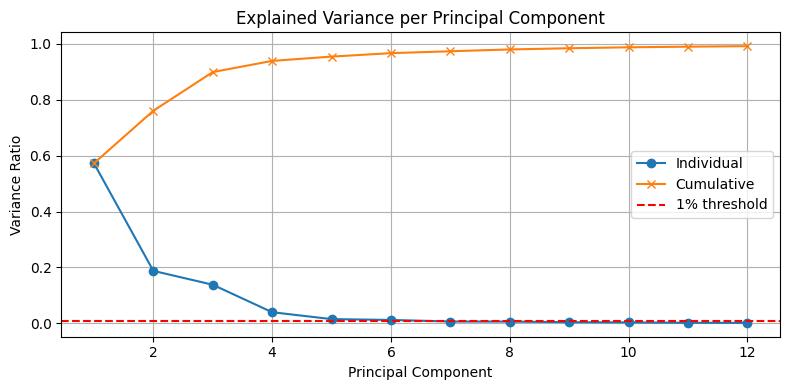

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assume pca is your trained PCA model
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained_var) + 1), explained_var, marker='o', label="Individual")
plt.plot(np.arange(1, len(explained_var) + 1), cumulative_var, marker='x', label="Cumulative")
plt.axhline(0.01, linestyle='--', color='red', label='1% threshold')
plt.title("Explained Variance per Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../notebooks/saved_images/pca_explained_variance.png", dpi=300, bbox_inches='tight')
plt.show()



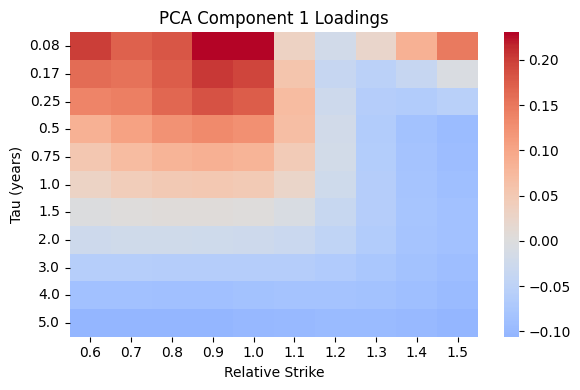

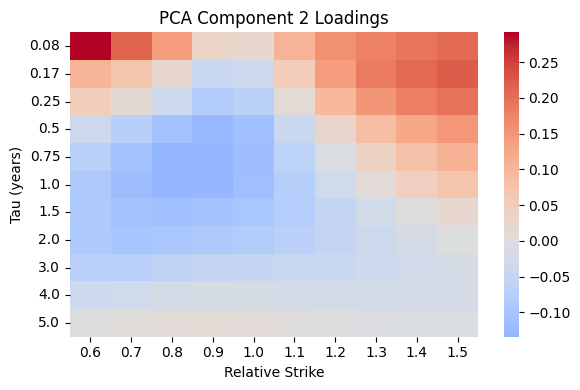

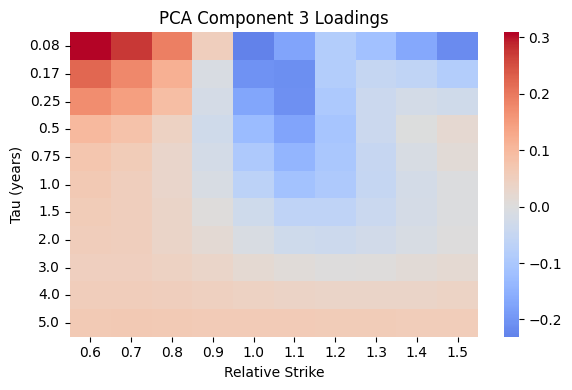

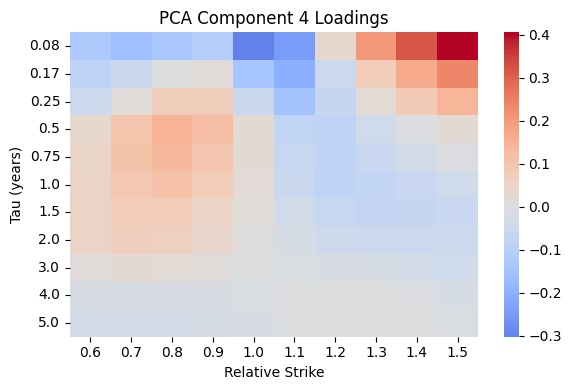

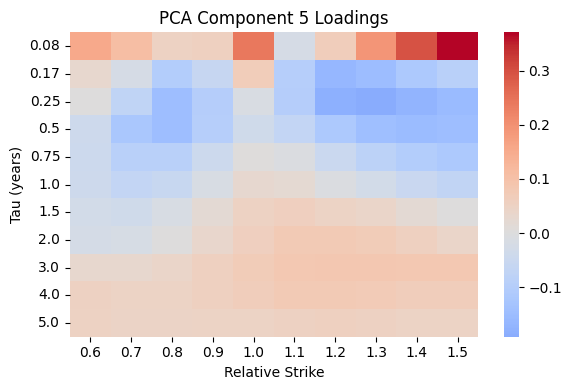

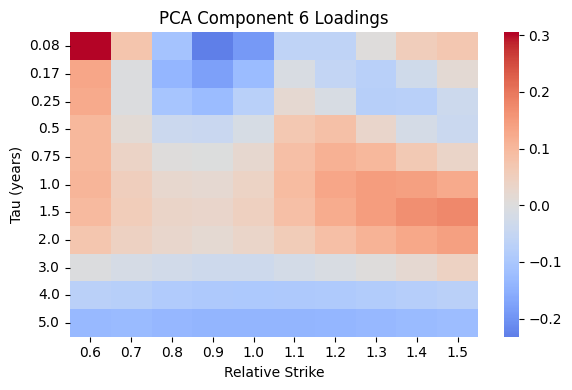

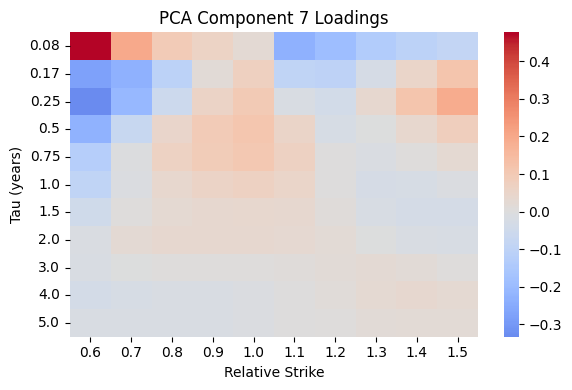

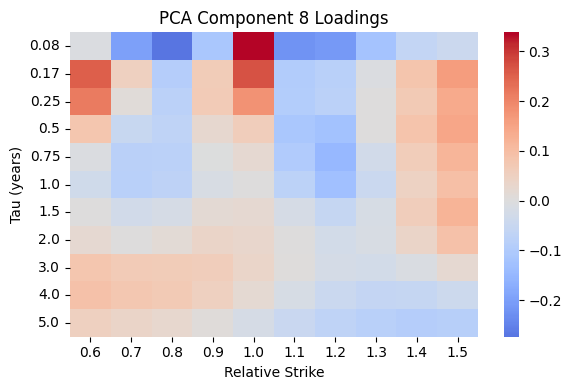

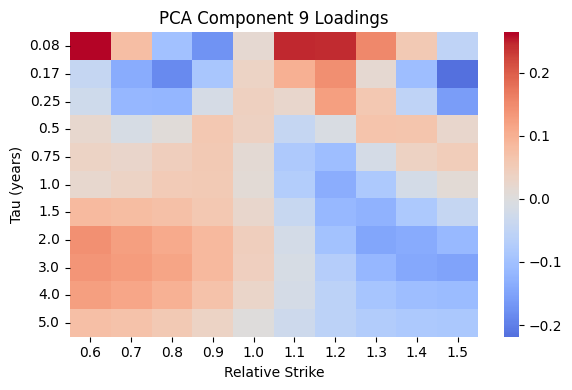

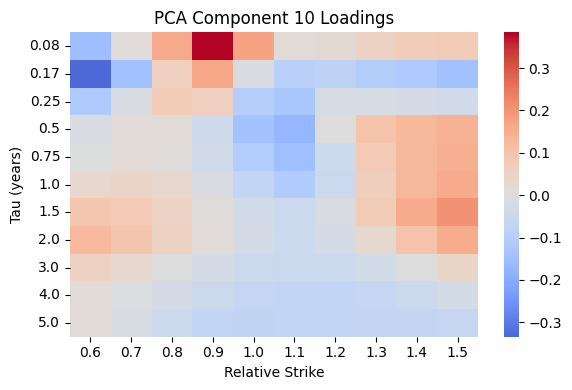

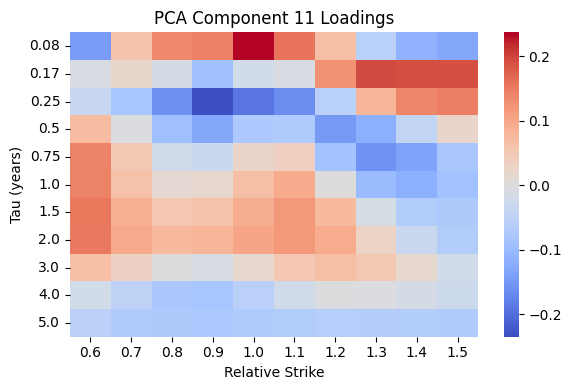

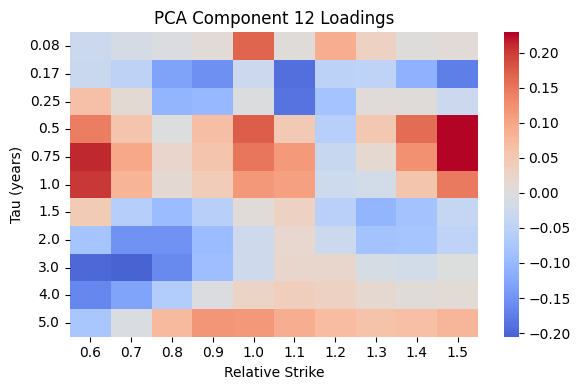

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape each component to (M, K) and plot
components = pca.components_  # shape: (LATENT_DIM, M*K)

for i, comp in enumerate(components):
    loading = comp.reshape(M, K)
    plt.figure(figsize=(6, 4))
    sns.heatmap(loading, cmap="coolwarm", center=0,
                xticklabels=np.round(rel_strikes, 2),
                yticklabels=np.round(taus, 2))
    plt.title(f"PCA Component {i+1} Loadings")
    plt.xlabel("Relative Strike")
    plt.ylabel("Tau (years)")
    plt.tight_layout()
    plt.savefig(f"../notebooks/saved_images/pca_component_{i+1}_loadings.png", dpi=300, bbox_inches='tight')
    plt.show()


### Summary of Baseline PCA-VAR Methodology and Results

#### Key Implementation Takeaways

One of the most critical insights from the baseline PCA-VAR approach is that surface normalization is less effective than surface-wise demeaning. Specifically, removing the mean from each implied volatility surface before applying PCA — and then reintroducing that mean after reconstruction — leads to much more stable forecasts. This approach respects the overall level of volatility while allowing PCA to focus on variations in surface shape.

We also compared two strategies for dimensionality reduction: pointwise PCA and surface-wise PCA. In the pointwise method, each of the 110 (moneyness × maturity) time series is treated independently. This allows PCA to extract shared variation across those time series, and the latent dynamics modeled via VAR remain stable. In contrast, surface-wise PCA flattens the entire surface into a single vector per day and performs PCA across those. While this captures macro-level dynamics, it can struggle to model localized, nonlinear effects, particularly in extreme regions of the surface.

An important extension came from augmenting the PCA latent vector with macro and smile-related features. By engineering features such as log returns, interest rate slope and curvature, realized volatility, and smile skew/convexity, we found a consistent improvement in RMSE and surface reconstruction accuracy.

#### Empirical Observations

Our heatmaps of MAE and RMSE across the τ × m grid show that errors are concentrated at short maturities and extreme strikes. This reflects the higher nonlinearity and curvature of the IV surface in those regions, which PCA — being a linear method — fails to fully capture. These patterns are visually evident and consistent across multiple configurations.

Additionally, analysis of the PCA component loadings supports these findings. The first principal component explains the overall level and term structure slope of volatility, while the second component captures smile asymmetry. However, beyond the second or third component, PCA tends to encode noise or idiosyncratic patterns that don’t generalize well.

#### Limitations of Linear PCA-VAR

Despite the strong performance in central regions of the surface, PCA-VAR underperforms in areas requiring fine-grained shape reconstruction, such as the wings of the smile or short-dated tenors. The linear structure of PCA is unable to capture rare but structurally significant surface deformations. Moreover, PCA’s orthogonal basis constraint may limit interpretability and restrict its capacity to disentangle overlapping dynamics like level, slope, and skew.

This linear bottleneck also affects temporal dynamics. While VAR can model simple autoregressive dependencies, it fails to capture volatility clustering, asymmetric mean-reversion, or memory effects across maturities.

#### Motivation for Nonlinear and Local Models

To address these limitations, we motivate a transition to nonlinear, decoder-based pipelines. Neural decoders can model localized variation in the surface and can express complex patterns without being restricted to linear orthogonal bases. By learning a decoder over latent representations, we can allow different dimensions to specialize in structural components like term shifts, smile skew, or calendar spreads.

Moreover, forecasting the latent dynamics using sequence models such as LSTMs or Transformers allows us to capture long-range dependencies and regime transitions in volatility. These models are particularly important in the presence of macro shocks or periods of structural change.

In summary, while PCA-VAR offers a strong linear benchmark, its limitations in modeling surface tails, temporal heterogeneity, and nonlinear deformation motivate the introduction of deep learning-based volatility surface modeling pipelines.


---
---
